# Titanic spaceship
## Introduction

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

cf [here](https://www.kaggle.com/competitions/spaceship-titanic)

In [1]:
# imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# options

custom_colors = [
    (100/255, 108/255, 116/255),   # nevada
    (228/255, 12/255, 33/255),     # red-ribbon
    (68/255, 68/255, 76/255),      # abbey
    (172/255, 28/255, 44/255),     # roof-terracotta 
]
custom_palette = sns.color_palette(custom_colors)
custom_palette

[(0.39215686274509803, 0.4235294117647059, 0.4549019607843137),
 (0.8941176470588236, 0.047058823529411764, 0.12941176470588237),
 (0.26666666666666666, 0.26666666666666666, 0.2980392156862745),
 (0.6745098039215687, 0.10980392156862745, 0.17254901960784313)]

## Read data

In [3]:
train_df = pd.read_csv("./samples/train.csv")
train_df['Transported'] = train_df['Transported'].astype(int)
test_df = pd.read_csv("./samples/test.csv")
df = pd.concat([train_df, test_df], axis=0)
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0


## Explaination

- train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
   - ```PassengerId``` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
   - ```HomePlanet``` - The planet the passenger departed from, typically their planet of permanent residence.
   - ```CryoSleep``` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
   - ```Cabin``` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
   - ```Destination``` - The planet the passenger will be debarking to.
   - ```Age``` - The age of the passenger.
   - ```VIP``` - Whether the passenger has paid for special VIP service during the voyage.
   - ```RoomService, FoodCourt, ShoppingMall, Spa, VRDeck``` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
   - ```Name``` - The first and last names of the passenger.
   - ```Transported``` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
- test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
- sample_submission.csv - A submission file in the correct format.
   - ```PassengerId``` - Id for each passenger in the test set.
   - ```Transported``` - The target. For each passenger, predict either True or False.

## Summary

we'll see if some data is missing or duplicated

In [4]:
def summary(df):
    print(f"Dataset has {df.shape[1]} features and {df.shape[0]} examples.")
    summary = pd.DataFrame(index=df.columns)
    summary["Unique"] = df.nunique().values
    summary["Missing"] = df.isnull().sum().values
    summary["Duplicated"] = df.duplicated().sum()
    summary["Types"] = df.dtypes
    return summary
summary(df)

Dataset has 14 features and 12970 examples.


,Unique,Missing,Duplicated,Types
PassengerId,12970,0,0,object
HomePlanet,3,288,0,object
CryoSleep,2,310,0,object
Cabin,9825,299,0,object
Destination,3,274,0,object
Age,80,270,0,float64
VIP,2,296,0,object
RoomService,1578,263,0,float64
FoodCourt,1953,289,0,float64
ShoppingMall,1367,306,0,float64


In [5]:
# repartition of values in our dataset
transported_count = df[(df["Transported"] == True)]["Transported"].count()
untransported_count = df[(df["Transported"] == False)]["Transported"].count()
print(f"Transported passengers count: {transported_count} ({(transported_count / df.shape[0]) * 100 :.2f}%)")
print(f"Untransported passengers count: {untransported_count} ({(untransported_count / df.shape[0]) * 100 :.2f}%)")

Transported passengers count: 4378 (33.75%)
Untransported passengers count: 4315 (33.27%)


## Wrangling data

we have to improve our data, replace missing values...

### PassengerId

we can get ```gggg```, the passenger group and convert it to group size to estimate a new parameter, the correlation with the ```Transported``` parameter will be more efficient

In [6]:
group = df['PassengerId'].apply(lambda x: x.split('_')[0]).value_counts().to_dict()
df['Group_size'] = df['PassengerId'].apply(lambda x: group[x.split('_')[0]])
df.set_index('PassengerId', inplace=True)
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group_size
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0,1
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0,1
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0,2
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0,2
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0,1


### HomePlanet

We have 201 missing values for homeplanet, we can get the average of existing values and apply to them

In [7]:
df["HomePlanet"].value_counts()

Earth     6865
Europa    3133
Mars      2684
Name: HomePlanet, dtype: int64

In [8]:
avg = df["HomePlanet"].value_counts()
percentage = avg.values / sum(avg.values)
percentage

array([0.5413184 , 0.24704305, 0.21163854])

In [9]:
# replace NaN values by random existing value
df.loc[df['HomePlanet'].isna(), 'HomePlanet'] = np.random.choice(avg.index, df['HomePlanet'].isna().sum(), p=percentage)

### CryoSleep
We have 217 missing values for CryoSleep, we can define those like False

In [10]:
df["CryoSleep"].fillna(False, inplace=True)
df['CryoSleep'] = df['CryoSleep'].astype(int) # bool to int

### Cabin
We have 199 missing values, we have to split this data in deck/num/side

In [11]:
df[["CabinDeck", "CabinNum", "CabinSide"]] = df["Cabin"].str.split("/", n=2, expand=True)
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group_size,CabinDeck,CabinNum,CabinSide
PassengerId,,,,,,,,,,,,,,,,,
0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0,1,B,0,P
0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0,1,F,0,S
0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0,2,A,0,S
0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0,2,A,0,S
0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0,1,F,1,S


### Cabin-Deck
replace NaN value with most available value

In [12]:
df["CabinDeck"].value_counts()

F    4239
G    3781
E    1323
B    1141
C    1102
D     720
A     354
T      11
Name: CabinDeck, dtype: int64

In [13]:
# Generate random choices between 'F' and 'G'
# Replace NaN values with random choices
df['CabinDeck'] = df['CabinDeck'].fillna(df['CabinDeck'].apply(lambda x: np.random.choice(['F', 'G']) if pd.isna(x) else x))
df["CabinDeck"].value_counts()

F    4371
G    3948
E    1323
B    1141
C    1102
D     720
A     354
T      11
Name: CabinDeck, dtype: int64

### Cabin-num
replace NaN values with mean values

In [14]:
df["CabinNum"].value_counts()

82      34
4       28
56      28
95      27
31      27
        ..
1848     1
1847     1
1846     1
1844     1
1890     1
Name: CabinNum, Length: 1894, dtype: int64

In [15]:
mean = round(df["CabinNum"].astype(float).mean())
print(mean)
df["CabinNum"].fillna(mean, inplace=True)
df["CabinNum"] = df["CabinNum"].astype(int)
df["CabinNum"]

604


PassengerId
0001_01       0
0002_01       0
0003_01       0
0003_02       0
0004_01       1
           ... 
9266_02    1496
9269_01     604
9271_01     296
9273_01     297
9277_01    1498
Name: CabinNum, Length: 12970, dtype: int32

### Cabin-side

replace NaN values with random value between S or P

In [16]:
# Generate random choices between 'F' and 'G'
print(df["CabinSide"].value_counts())
# Replace NaN values with random choices
df['CabinSide'] = df['CabinSide'].fillna(df['CabinSide'].apply(lambda x: np.random.choice(['S', 'P']) if pd.isna(x) else x))

df["CabinSide"] = df["CabinSide"].map({'S': 0, 'P': 1})
df["CabinSide"]

S    6381
P    6290
Name: CabinSide, dtype: int64


PassengerId
0001_01    1
0002_01    0
0003_01    0
0003_02    0
0004_01    0
          ..
9266_02    0
9269_01    0
9271_01    1
9273_01    1
9277_01    0
Name: CabinSide, Length: 12970, dtype: int64

In [17]:
df.drop("Cabin", axis=1, inplace=True)
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group_size,CabinDeck,CabinNum,CabinSide
PassengerId,,,,,,,,,,,,,,,,
0001_01,Europa,0,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0,1,B,0,1
0002_01,Earth,0,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0,1,F,0,0
0003_01,Europa,0,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0,2,A,0,0
0003_02,Europa,0,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0,2,A,0,0
0004_01,Earth,0,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0,1,F,1,0


### Destination

we have 182 missing values, let's replace them with destinations average

In [18]:
df["Destination"].value_counts()

TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
Name: Destination, dtype: int64

In [19]:
avg = df["Destination"].value_counts()
percentage = avg.values / sum(avg.values)
percentage

array([0.69872401, 0.20801827, 0.09325772])

In [20]:
df.loc[df['Destination'].isna(), 'Destination'] = np.random.choice(avg.index, df['Destination'].isna().sum(), p=percentage)

### Age
we have 179 missing values, let's replace them with mean

In [21]:
age_mean = round(df["Age"].mean())
age_mean

29

In [22]:
df["Age"].fillna(mean, inplace=True)

### VIP
we have 203 missing values, let's replace them with False

In [23]:
df["VIP"].fillna(False, inplace=True)
df["VIP"] = df["VIP"].astype(int)

### Total amount
we concat RoomService, FoodCourt, ShoppingMall, Spa, VRDeck to get the total amount of passsenger amenities

In [24]:
## replaces missing values with mean
## roomService
room_mean = round(df["RoomService"].mean())
print(f"RoomService mean: {room_mean}€")
df["RoomService"].fillna(room_mean, inplace=True)
## FoodCourt
food_mean = round(df["FoodCourt"].mean())
print(f"FoodCourt mean: {food_mean}€")
df["FoodCourt"].fillna(food_mean, inplace=True)
## ShoppingMail
shop_mean = round(df["ShoppingMall"].mean())
print(f"ShoppingMall mean: {shop_mean}€")
df["ShoppingMall"].fillna(shop_mean, inplace=True)
## Spa
spa_mean = round(df["Spa"].mean())
print(f"Spa mean: {spa_mean}€")
df["Spa"].fillna(spa_mean, inplace=True)
## VRDeck
vr_mean = round(df["VRDeck"].mean())
print(f"VR mean: {vr_mean}€")
df["VRDeck"].fillna(vr_mean, inplace=True)

RoomService mean: 223€
FoodCourt mean: 452€
ShoppingMall mean: 175€
Spa mean: 308€
VR mean: 307€


In [25]:
df["Total_amount"] = df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)
df.drop(["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"], axis=1, inplace=True)
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,Name,Transported,Group_size,CabinDeck,CabinNum,CabinSide,Total_amount
PassengerId,,,,,,,,,,,,
0001_01,Europa,0,TRAPPIST-1e,39.0,0,Maham Ofracculy,0.0,1,B,0,1,0.0
0002_01,Earth,0,TRAPPIST-1e,24.0,0,Juanna Vines,1.0,1,F,0,0,736.0
0003_01,Europa,0,TRAPPIST-1e,58.0,1,Altark Susent,0.0,2,A,0,0,10383.0
0003_02,Europa,0,TRAPPIST-1e,33.0,0,Solam Susent,0.0,2,A,0,0,5176.0
0004_01,Earth,0,TRAPPIST-1e,16.0,0,Willy Santantines,1.0,1,F,1,0,1091.0


### Name
replace NaN values with Unk Unk and encode name to improve our model

In [26]:
df["Name"].fillna("Unk Unk", inplace=True)

In [27]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
df[['First_name', 'Last_name']] = df['Name'].str.split(' ', 1, expand=True)
df["First_name"] = encoder.fit_transform(df["First_name"])
df["Last_name"] = encoder.fit_transform(df["Last_name"])

# Drop the original full_name column if desired
df.drop('Name', axis=1, inplace=True)
df.head()

C:\Users\adrie\AppData\Local\Temp\ipykernel_16036\1586171271.py:3: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['First_name', 'Last_name']] = df['Name'].str.split(' ', 1, expand=True)


,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Group_size,CabinDeck,CabinNum,CabinSide,Total_amount,First_name,Last_name
PassengerId,,,,,,,,,,,,,
0001_01,Europa,0,TRAPPIST-1e,39.0,0,0.0,1,B,0,1,0.0,1708,1551
0002_01,Earth,0,TRAPPIST-1e,24.0,0,1.0,1,F,0,0,736.0,1493,2290
0003_01,Europa,0,TRAPPIST-1e,58.0,1,0.0,2,A,0,0,10383.0,170,2153
0003_02,Europa,0,TRAPPIST-1e,33.0,0,0.0,2,A,0,0,5176.0,2424,2153
0004_01,Earth,0,TRAPPIST-1e,16.0,0,1.0,1,F,1,0,1091.0,2816,1924


In [28]:
## check summary
summary(df)

Dataset has 13 features and 12970 examples.


,Unique,Missing,Duplicated,Types
HomePlanet,3,0,0,object
CryoSleep,2,0,0,int32
Destination,3,0,0,object
Age,81,0,0,float64
VIP,2,0,0,int32
Transported,2,4277,0,float64
Group_size,8,0,0,int64
CabinDeck,8,0,0,object
CabinNum,1894,0,0,int32
CabinSide,2,0,0,int64


## One-hot encoding
we have to transform our data

In [29]:
features = ["HomePlanet", "Destination", "CabinDeck"]
df = pd.concat([df, pd.get_dummies(df[features])], axis=1)
df.drop(columns=features, inplace=True)
df.head()

,CryoSleep,Age,VIP,Transported,Group_size,CabinNum,CabinSide,Total_amount,First_name,Last_name,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,0,39.0,0,0.0,1,0,1,0.0,1708,1551,...,0,1,0,1,0,0,0,0,0,0
0002_01,0,24.0,0,1.0,1,0,0,736.0,1493,2290,...,0,1,0,0,0,0,0,1,0,0
0003_01,0,58.0,1,0.0,2,0,0,10383.0,170,2153,...,0,1,1,0,0,0,0,0,0,0
0003_02,0,33.0,0,0.0,2,0,0,5176.0,2424,2153,...,0,1,1,0,0,0,0,0,0,0
0004_01,0,16.0,0,1.0,1,1,0,1091.0,2816,1924,...,0,1,0,0,0,0,0,1,0,0


In [45]:
# split train / test data
test_df  = df[train_df.shape[0]:]
train_df = df[:train_df.shape[0]]

# test data
X_test = test_df.drop("Transported", axis=1)

In [46]:
X_test.head()

,CryoSleep,Age,VIP,Group_size,CabinNum,CabinSide,Total_amount,First_name,Last_name,HomePlanet_Earth,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
0013_01,1,27.0,0,1,3,0,0.0,1943,373,1,...,0,1,0,0,0,0,0,0,1,0
0018_01,0,19.0,0,1,4,0,2832.0,1613,1628,1,...,0,1,0,0,0,0,0,1,0,0
0019_01,1,31.0,0,1,0,0,0.0,2276,2244,0,...,0,0,0,0,1,0,0,0,0,0
0021_01,0,38.0,0,1,1,0,7418.0,1800,350,0,...,0,1,0,0,1,0,0,0,0,0
0023_01,0,20.0,0,1,5,0,645.0,487,1016,1,...,0,1,0,0,0,0,0,1,0,0


## Correlation

<Axes: >

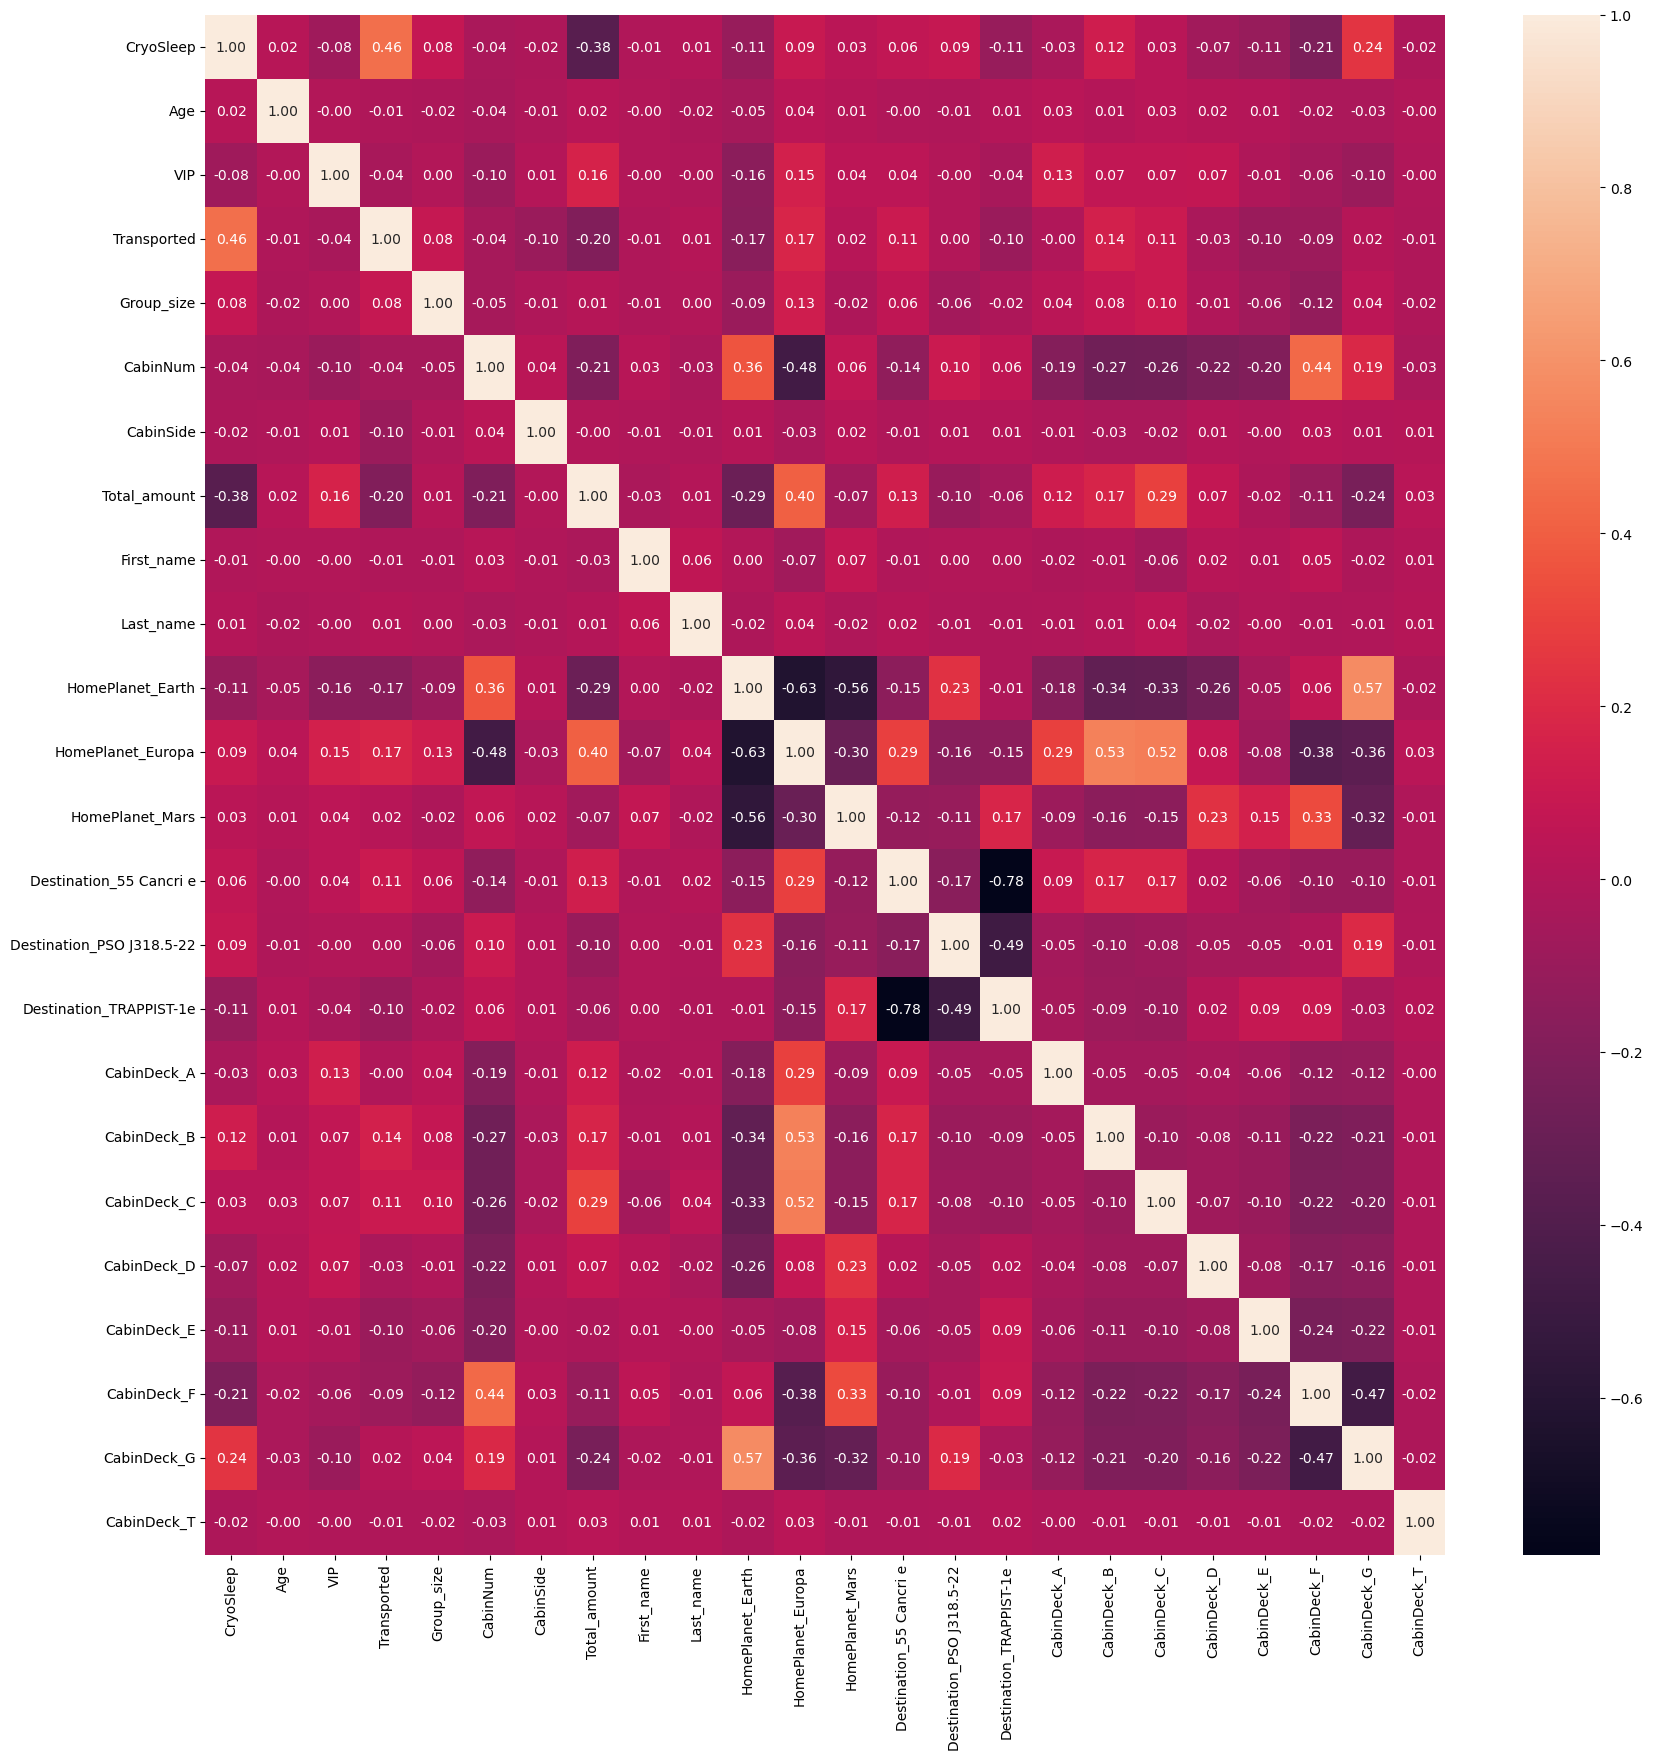

In [31]:
# correlation
f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(train_df.corr(), annot = True, fmt= '.2f')

we see that ```CryoSleep``` have a strong correlation with ```Transported``` status

# Split train, validation data
now we have to separate our data in train and validation set

In [32]:
from sklearn.model_selection import train_test_split
y = train_df["Transported"]
X = train_df.drop("Transported", axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.125, random_state=42)

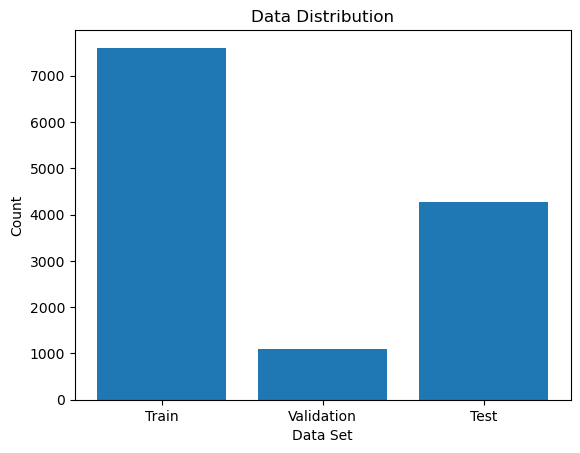

In [33]:
train_count = X_train.shape[0]
val_count = X_val.shape[0]
test_count = test_df.shape[0]

labels = ['Train', 'Validation', 'Test']
counts = [train_count, val_count, test_count]

plt.bar(labels, counts)

plt.title('Data Distribution')
plt.xlabel('Data Set')
plt.ylabel('Count')

# Display the chart
plt.show()

# Model

we are going to fit differents models and evaluate them to keep the best one
- KNeighborsClassifier
- RandomForestClassifier
- Neural Network (MLPClassifier)
- HistGradientBoostingClassifier
- CatBoostClassifier

In [34]:
# import models

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

## KNeighborsClassifier

Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.69      0.69       562
         1.0       0.67      0.68      0.67       525

    accuracy                           0.68      1087
   macro avg       0.68      0.68      0.68      1087
weighted avg       0.68      0.68      0.68      1087



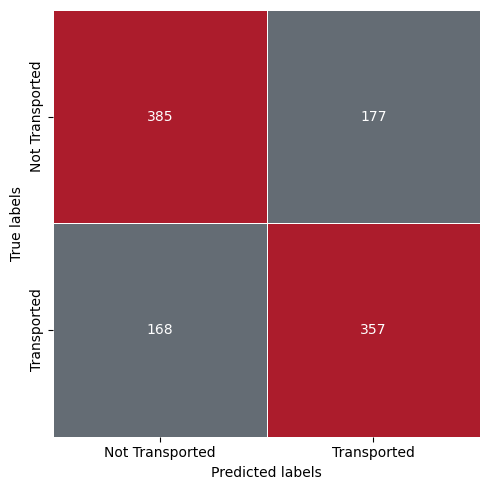

In [35]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_val)

# Create a classification report
report = classification_report(y_val, y_pred)
print("Classification Report:\n", report)

# accuracy
cv_knn = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy').mean()

# Create a confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create a heatmap of the confusion matrix
fig, axs = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', ax=axs, linewidths=0.5, cmap=custom_palette, cbar=False)
axs.set_xlabel('Predicted labels')
axs.set_ylabel('True labels'); 
axs.xaxis.set_ticklabels(['Not Transported', 'Transported'])
axs.yaxis.set_ticklabels(['Not Transported', 'Transported']);
plt.tight_layout()

## RandomForestClassifier

Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.81      0.77       562
         1.0       0.77      0.67      0.72       525

    accuracy                           0.75      1087
   macro avg       0.75      0.74      0.74      1087
weighted avg       0.75      0.75      0.74      1087



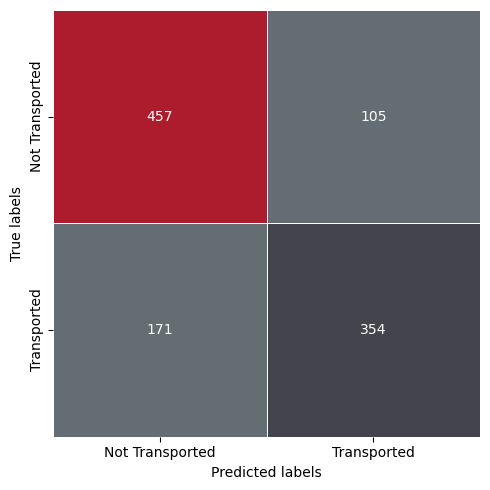

In [36]:
rff = RandomForestClassifier()
rff.fit(X_train, y_train)

y_pred = rff.predict(X_val)

# Create a classification report
report = classification_report(y_val, y_pred)
print("Classification Report:\n", report)

# accuracy
cv_rff = cross_val_score(rff, X_train, y_train, cv=5, scoring='accuracy').mean()

# Create a confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create a heatmap of the confusion matrix
fig, axs = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', ax=axs, linewidths=0.5, cmap=custom_palette, cbar=False)
axs.set_xlabel('Predicted labels')
axs.set_ylabel('True labels'); 
axs.xaxis.set_ticklabels(['Not Transported', 'Transported'])
axs.yaxis.set_ticklabels(['Not Transported', 'Transported']);
plt.tight_layout()

Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.56      0.62       562
         1.0       0.61      0.74      0.67       525

    accuracy                           0.65      1087
   macro avg       0.66      0.65      0.65      1087
weighted avg       0.66      0.65      0.65      1087



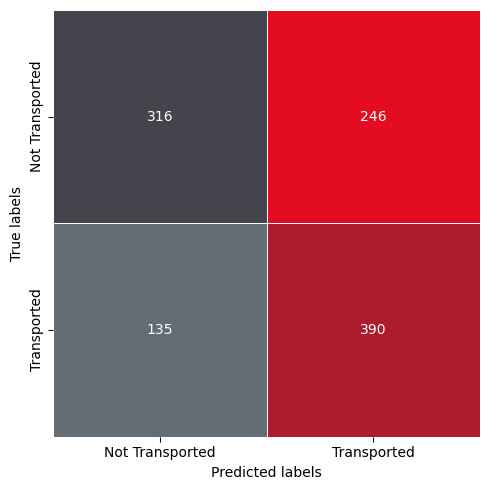

In [37]:
from sklearn.neural_network import MLPClassifier

network = MLPClassifier()
network.fit(X_train, y_train)

y_pred = network.predict(X_val)

# Create a classification report
report = classification_report(y_val, y_pred)
print("Classification Report:\n", report)

# Create a confusion matrix
cm = confusion_matrix(y_val, y_pred)

# accuracy
cv_network = cross_val_score(network, X_train, y_train, cv=5, scoring='accuracy').mean()

# Create a heatmap of the confusion matrix
fig, axs = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', ax=axs, linewidths=0.5, cmap=custom_palette, cbar=False)
axs.set_xlabel('Predicted labels')
axs.set_ylabel('True labels'); 
axs.xaxis.set_ticklabels(['Not Transported', 'Transported'])
axs.yaxis.set_ticklabels(['Not Transported', 'Transported']);
plt.tight_layout()

## HistGradientBoostingClassifier

Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      0.82      0.77       562
         1.0       0.78      0.69      0.73       525

    accuracy                           0.75      1087
   macro avg       0.76      0.75      0.75      1087
weighted avg       0.76      0.75      0.75      1087



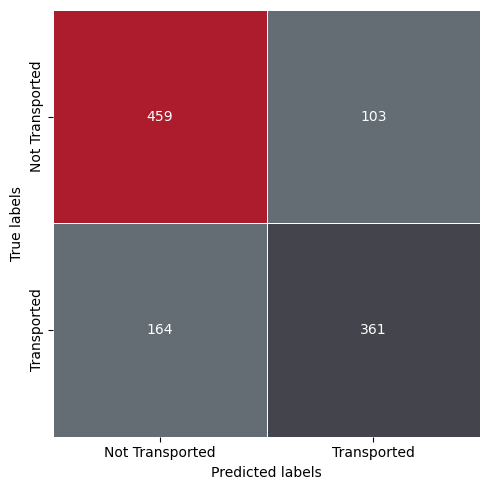

In [38]:
hg = HistGradientBoostingClassifier()

hg.fit(X_train, y_train)

y_pred = hg.predict(X_val)

# Create a classification report
report = classification_report(y_val, y_pred)
print("Classification Report:\n", report)

# Create a confusion matrix
cm = confusion_matrix(y_val, y_pred)

# accuracy
cv_hg = cross_val_score(hg, X_train, y_train, cv=5, scoring='accuracy').mean()

fig, axs = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', ax=axs, linewidths=0.5, cmap=custom_palette, cbar=False)
axs.set_xlabel('Predicted labels')
axs.set_ylabel('True labels'); 
axs.xaxis.set_ticklabels(['Not Transported', 'Transported'])
axs.yaxis.set_ticklabels(['Not Transported', 'Transported']);
plt.tight_layout()

## CatBoostClassifier

Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      0.82      0.78       562
         1.0       0.78      0.70      0.74       525

    accuracy                           0.76      1087
   macro avg       0.76      0.76      0.76      1087
weighted avg       0.76      0.76      0.76      1087



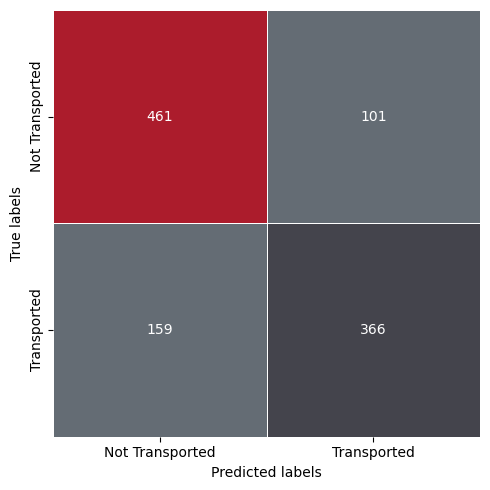

In [39]:
cat = CatBoostClassifier(verbose=False)

cat.fit(X_train, y_train)

y_pred = cat.predict(X_val)

# Create a classification report
report = classification_report(y_val, y_pred)
print("Classification Report:\n", report)

# Create a confusion matrix
cm = confusion_matrix(y_val, y_pred)

# accuracy
cv_cat = cross_val_score(cat, X_train, y_train, cv=5, scoring='accuracy').mean()

fig, axs = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', ax=axs, linewidths=0.5, cmap=custom_palette, cbar=False)
axs.set_xlabel('Predicted labels')
axs.set_ylabel('True labels'); 
axs.xaxis.set_ticklabels(['Not Transported', 'Transported'])
axs.yaxis.set_ticklabels(['Not Transported', 'Transported']);
plt.tight_layout()

### Accuracy

In [40]:
print(f"KNN accuracy: {cv_knn}")
print(f"RFF accuracy: {cv_rff}")
print(f"Network accuracy: {cv_network}")
print(f"HG accuracy: {cv_hg}")
print(f"CatBoost accuracy: {cv_cat}")

KNN accuracy: 0.6773594555763767
RFF accuracy: 0.7448071285835361
Network accuracy: 0.6636857970022834
HG accuracy: 0.7487513833920383
CatBoost accuracy: 0.7524333444782247


In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Assuming you have your features X_train, X_val, y_train, y_val

# Initialize CatBoost Classifier
model = CatBoostClassifier()

# Define the parameter grid for grid search
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 1],
    'iterations': [100, 200, 300]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Use the best model for predictions
best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy:", accuracy_val)

# Make predictions on the test data
y_pred_test = best_model.predict(X_test)

# Calculate the accuracy score for the test data
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", accuracy_test)

0:	learn: 0.6895211	total: 2.64ms	remaining: 261ms
1:	learn: 0.6856985	total: 5.2ms	remaining: 255ms
2:	learn: 0.6812645	total: 7.32ms	remaining: 237ms
3:	learn: 0.6775358	total: 9.7ms	remaining: 233ms
4:	learn: 0.6750118	total: 12.8ms	remaining: 243ms
5:	learn: 0.6720468	total: 15.5ms	remaining: 243ms
6:	learn: 0.6691813	total: 18.1ms	remaining: 241ms
7:	learn: 0.6658878	total: 20.6ms	remaining: 237ms
8:	learn: 0.6616391	total: 23ms	remaining: 233ms
9:	learn: 0.6585467	total: 25.8ms	remaining: 232ms
10:	learn: 0.6552189	total: 28.4ms	remaining: 230ms
11:	learn: 0.6519391	total: 31.4ms	remaining: 231ms
12:	learn: 0.6490109	total: 34.1ms	remaining: 229ms
13:	learn: 0.6464342	total: 36.8ms	remaining: 226ms
14:	learn: 0.6438098	total: 39.2ms	remaining: 222ms
15:	learn: 0.6410368	total: 41.7ms	remaining: 219ms
16:	learn: 0.6384524	total: 44.2ms	remaining: 216ms
17:	learn: 0.6359154	total: 46.5ms	remaining: 212ms
18:	learn: 0.6334321	total: 48.9ms	remaining: 208ms
19:	learn: 0.6301501	total

0:	learn: 0.6897079	total: 2.67ms	remaining: 264ms
1:	learn: 0.6859059	total: 5.63ms	remaining: 276ms
2:	learn: 0.6818503	total: 8.58ms	remaining: 278ms
3:	learn: 0.6782331	total: 11.4ms	remaining: 274ms
4:	learn: 0.6747957	total: 14ms	remaining: 266ms
5:	learn: 0.6716134	total: 16.4ms	remaining: 257ms
6:	learn: 0.6682146	total: 18.7ms	remaining: 249ms
7:	learn: 0.6649812	total: 21.3ms	remaining: 245ms
8:	learn: 0.6622062	total: 23.9ms	remaining: 242ms
9:	learn: 0.6591066	total: 26.5ms	remaining: 238ms
10:	learn: 0.6561367	total: 28.9ms	remaining: 234ms
11:	learn: 0.6531390	total: 31.3ms	remaining: 229ms
12:	learn: 0.6501435	total: 33.8ms	remaining: 226ms
13:	learn: 0.6476052	total: 36.2ms	remaining: 222ms
14:	learn: 0.6447788	total: 38.9ms	remaining: 220ms
15:	learn: 0.6422298	total: 41.8ms	remaining: 219ms
16:	learn: 0.6400179	total: 44.5ms	remaining: 217ms
17:	learn: 0.6375551	total: 47.2ms	remaining: 215ms
18:	learn: 0.6351944	total: 49.7ms	remaining: 212ms
19:	learn: 0.6322826	tot

18:	learn: 0.5134583	total: 47.2ms	remaining: 201ms
19:	learn: 0.5120322	total: 49.9ms	remaining: 199ms
20:	learn: 0.5100003	total: 52.4ms	remaining: 197ms
21:	learn: 0.5088941	total: 55.2ms	remaining: 196ms
22:	learn: 0.5073395	total: 57.8ms	remaining: 194ms
23:	learn: 0.5064985	total: 60.6ms	remaining: 192ms
24:	learn: 0.5057414	total: 64.3ms	remaining: 193ms
25:	learn: 0.5036332	total: 66.7ms	remaining: 190ms
26:	learn: 0.5027877	total: 69.3ms	remaining: 187ms
27:	learn: 0.5018870	total: 71.7ms	remaining: 184ms
28:	learn: 0.5008375	total: 74.1ms	remaining: 181ms
29:	learn: 0.5005474	total: 76.7ms	remaining: 179ms
30:	learn: 0.5001815	total: 79.4ms	remaining: 177ms
31:	learn: 0.4992997	total: 81.9ms	remaining: 174ms
32:	learn: 0.4989040	total: 84.3ms	remaining: 171ms
33:	learn: 0.4981509	total: 86.8ms	remaining: 168ms
34:	learn: 0.4978597	total: 89.2ms	remaining: 166ms
35:	learn: 0.4974508	total: 91.7ms	remaining: 163ms
36:	learn: 0.4952165	total: 94.2ms	remaining: 160ms
37:	learn: 0

29:	learn: 0.4113877	total: 77ms	remaining: 180ms
30:	learn: 0.4096274	total: 79.9ms	remaining: 178ms
31:	learn: 0.4080965	total: 82.3ms	remaining: 175ms
32:	learn: 0.4067739	total: 84.9ms	remaining: 172ms
33:	learn: 0.4047768	total: 87.4ms	remaining: 170ms
34:	learn: 0.4021271	total: 89.8ms	remaining: 167ms
35:	learn: 0.3994810	total: 92.4ms	remaining: 164ms
36:	learn: 0.3981506	total: 94.9ms	remaining: 162ms
37:	learn: 0.3960568	total: 97.5ms	remaining: 159ms
38:	learn: 0.3930106	total: 99.9ms	remaining: 156ms
39:	learn: 0.3913366	total: 102ms	remaining: 154ms
40:	learn: 0.3893891	total: 105ms	remaining: 151ms
41:	learn: 0.3873861	total: 107ms	remaining: 148ms
42:	learn: 0.3862572	total: 110ms	remaining: 146ms
43:	learn: 0.3842061	total: 112ms	remaining: 143ms
44:	learn: 0.3823761	total: 115ms	remaining: 140ms
45:	learn: 0.3804865	total: 117ms	remaining: 138ms
46:	learn: 0.3779097	total: 120ms	remaining: 135ms
47:	learn: 0.3754006	total: 122ms	remaining: 133ms
48:	learn: 0.3742413	to

50:	learn: 0.3779424	total: 126ms	remaining: 121ms
51:	learn: 0.3766679	total: 129ms	remaining: 119ms
52:	learn: 0.3748258	total: 132ms	remaining: 117ms
53:	learn: 0.3735081	total: 134ms	remaining: 114ms
54:	learn: 0.3716299	total: 137ms	remaining: 112ms
55:	learn: 0.3698061	total: 139ms	remaining: 109ms
56:	learn: 0.3684277	total: 142ms	remaining: 107ms
57:	learn: 0.3664738	total: 144ms	remaining: 105ms
58:	learn: 0.3652541	total: 147ms	remaining: 102ms
59:	learn: 0.3631508	total: 149ms	remaining: 99.5ms
60:	learn: 0.3615068	total: 152ms	remaining: 97ms
61:	learn: 0.3601050	total: 154ms	remaining: 94.5ms
62:	learn: 0.3585005	total: 157ms	remaining: 92ms
63:	learn: 0.3558879	total: 159ms	remaining: 89.5ms
64:	learn: 0.3545042	total: 161ms	remaining: 86.9ms
65:	learn: 0.3518277	total: 164ms	remaining: 84.4ms
66:	learn: 0.3503453	total: 166ms	remaining: 81.9ms
67:	learn: 0.3476306	total: 169ms	remaining: 79.4ms
68:	learn: 0.3455183	total: 171ms	remaining: 76.9ms
69:	learn: 0.3430068	tota

179:	learn: 0.5146481	total: 446ms	remaining: 49.5ms
180:	learn: 0.5142908	total: 449ms	remaining: 47.1ms
181:	learn: 0.5141942	total: 452ms	remaining: 44.7ms
182:	learn: 0.5139026	total: 455ms	remaining: 42.2ms
183:	learn: 0.5137528	total: 457ms	remaining: 39.8ms
184:	learn: 0.5136056	total: 460ms	remaining: 37.3ms
185:	learn: 0.5134019	total: 462ms	remaining: 34.8ms
186:	learn: 0.5132769	total: 465ms	remaining: 32.3ms
187:	learn: 0.5130285	total: 467ms	remaining: 29.8ms
188:	learn: 0.5128478	total: 470ms	remaining: 27.3ms
189:	learn: 0.5125985	total: 472ms	remaining: 24.9ms
190:	learn: 0.5122839	total: 475ms	remaining: 22.4ms
191:	learn: 0.5119974	total: 478ms	remaining: 19.9ms
192:	learn: 0.5118468	total: 480ms	remaining: 17.4ms
193:	learn: 0.5117009	total: 483ms	remaining: 14.9ms
194:	learn: 0.5115476	total: 485ms	remaining: 12.4ms
195:	learn: 0.5112577	total: 488ms	remaining: 9.95ms
196:	learn: 0.5111882	total: 490ms	remaining: 7.46ms
197:	learn: 0.5109336	total: 493ms	remaining: 

0:	learn: 0.6897079	total: 3.11ms	remaining: 619ms
1:	learn: 0.6859059	total: 6.35ms	remaining: 629ms
2:	learn: 0.6818503	total: 9.51ms	remaining: 625ms
3:	learn: 0.6782331	total: 12.3ms	remaining: 604ms
4:	learn: 0.6747957	total: 14.6ms	remaining: 570ms
5:	learn: 0.6716134	total: 17ms	remaining: 549ms
6:	learn: 0.6682146	total: 19.4ms	remaining: 536ms
7:	learn: 0.6649812	total: 21.8ms	remaining: 524ms
8:	learn: 0.6622062	total: 24.2ms	remaining: 514ms
9:	learn: 0.6591066	total: 26.6ms	remaining: 506ms
10:	learn: 0.6561367	total: 29ms	remaining: 499ms
11:	learn: 0.6531390	total: 31.4ms	remaining: 491ms
12:	learn: 0.6501435	total: 34.6ms	remaining: 497ms
13:	learn: 0.6476052	total: 37.6ms	remaining: 500ms
14:	learn: 0.6447788	total: 40.7ms	remaining: 502ms
15:	learn: 0.6422298	total: 43.4ms	remaining: 499ms
16:	learn: 0.6400179	total: 45.9ms	remaining: 494ms
17:	learn: 0.6375551	total: 48.2ms	remaining: 487ms
18:	learn: 0.6351944	total: 50.7ms	remaining: 483ms
19:	learn: 0.6322826	total

26:	learn: 0.5021596	total: 67.1ms	remaining: 430ms
27:	learn: 0.5015211	total: 69.8ms	remaining: 429ms
28:	learn: 0.5006003	total: 72.7ms	remaining: 429ms
29:	learn: 0.4987408	total: 75.2ms	remaining: 426ms
30:	learn: 0.4974705	total: 77.5ms	remaining: 422ms
31:	learn: 0.4957214	total: 80.1ms	remaining: 420ms
32:	learn: 0.4952401	total: 83.1ms	remaining: 421ms
33:	learn: 0.4949005	total: 85.6ms	remaining: 418ms
34:	learn: 0.4940780	total: 88.4ms	remaining: 417ms
35:	learn: 0.4927038	total: 91.1ms	remaining: 415ms
36:	learn: 0.4920506	total: 93.6ms	remaining: 413ms
37:	learn: 0.4912932	total: 96.1ms	remaining: 410ms
38:	learn: 0.4889653	total: 98.6ms	remaining: 407ms
39:	learn: 0.4884675	total: 101ms	remaining: 405ms
40:	learn: 0.4881830	total: 104ms	remaining: 405ms
41:	learn: 0.4878202	total: 107ms	remaining: 402ms
42:	learn: 0.4875526	total: 109ms	remaining: 400ms
43:	learn: 0.4871437	total: 112ms	remaining: 397ms
44:	learn: 0.4866983	total: 114ms	remaining: 394ms
45:	learn: 0.48634

47:	learn: 0.4869581	total: 119ms	remaining: 375ms
48:	learn: 0.4865814	total: 121ms	remaining: 374ms
49:	learn: 0.4862941	total: 124ms	remaining: 371ms
50:	learn: 0.4858198	total: 126ms	remaining: 369ms
51:	learn: 0.4852213	total: 129ms	remaining: 367ms
52:	learn: 0.4847663	total: 132ms	remaining: 365ms
53:	learn: 0.4832774	total: 134ms	remaining: 363ms
54:	learn: 0.4819653	total: 137ms	remaining: 361ms
55:	learn: 0.4813910	total: 140ms	remaining: 361ms
56:	learn: 0.4809049	total: 145ms	remaining: 365ms
57:	learn: 0.4806508	total: 150ms	remaining: 367ms
58:	learn: 0.4802415	total: 157ms	remaining: 376ms
59:	learn: 0.4798272	total: 161ms	remaining: 377ms
60:	learn: 0.4794016	total: 166ms	remaining: 378ms
61:	learn: 0.4790511	total: 169ms	remaining: 376ms
62:	learn: 0.4787644	total: 173ms	remaining: 375ms
63:	learn: 0.4783382	total: 177ms	remaining: 377ms
64:	learn: 0.4780479	total: 181ms	remaining: 376ms
65:	learn: 0.4777742	total: 185ms	remaining: 375ms
66:	learn: 0.4775659	total: 188

50:	learn: 0.4894930	total: 197ms	remaining: 575ms
51:	learn: 0.4888706	total: 200ms	remaining: 569ms
52:	learn: 0.4882036	total: 203ms	remaining: 562ms
53:	learn: 0.4878435	total: 205ms	remaining: 555ms
54:	learn: 0.4873591	total: 209ms	remaining: 552ms
55:	learn: 0.4866328	total: 212ms	remaining: 546ms
56:	learn: 0.4862496	total: 215ms	remaining: 539ms
57:	learn: 0.4856888	total: 217ms	remaining: 532ms
58:	learn: 0.4852093	total: 220ms	remaining: 526ms
59:	learn: 0.4848711	total: 223ms	remaining: 521ms
60:	learn: 0.4843884	total: 226ms	remaining: 516ms
61:	learn: 0.4840777	total: 229ms	remaining: 510ms
62:	learn: 0.4831901	total: 232ms	remaining: 504ms
63:	learn: 0.4831327	total: 233ms	remaining: 496ms
64:	learn: 0.4827499	total: 236ms	remaining: 490ms
65:	learn: 0.4820187	total: 239ms	remaining: 486ms
66:	learn: 0.4816981	total: 243ms	remaining: 481ms
67:	learn: 0.4812530	total: 245ms	remaining: 476ms
68:	learn: 0.4810445	total: 248ms	remaining: 471ms
69:	learn: 0.4805834	total: 251

39:	learn: 0.3913366	total: 105ms	remaining: 420ms
40:	learn: 0.3893891	total: 108ms	remaining: 417ms
41:	learn: 0.3873861	total: 110ms	remaining: 415ms
42:	learn: 0.3862572	total: 113ms	remaining: 412ms
43:	learn: 0.3842061	total: 115ms	remaining: 409ms
44:	learn: 0.3823761	total: 118ms	remaining: 406ms
45:	learn: 0.3804865	total: 121ms	remaining: 404ms
46:	learn: 0.3779097	total: 123ms	remaining: 402ms
47:	learn: 0.3754006	total: 126ms	remaining: 400ms
48:	learn: 0.3742413	total: 129ms	remaining: 397ms
49:	learn: 0.3724166	total: 132ms	remaining: 395ms
50:	learn: 0.3710436	total: 134ms	remaining: 392ms
51:	learn: 0.3689555	total: 137ms	remaining: 389ms
52:	learn: 0.3672724	total: 139ms	remaining: 386ms
53:	learn: 0.3649243	total: 142ms	remaining: 384ms
54:	learn: 0.3608997	total: 144ms	remaining: 381ms
55:	learn: 0.3591813	total: 147ms	remaining: 379ms
56:	learn: 0.3571066	total: 150ms	remaining: 377ms
57:	learn: 0.3562461	total: 153ms	remaining: 374ms
58:	learn: 0.3546118	total: 156

23:	learn: 0.4323604	total: 68.1ms	remaining: 499ms
24:	learn: 0.4287289	total: 71.2ms	remaining: 499ms
25:	learn: 0.4268403	total: 75.3ms	remaining: 504ms
26:	learn: 0.4243956	total: 78.9ms	remaining: 505ms
27:	learn: 0.4232455	total: 81.7ms	remaining: 502ms
28:	learn: 0.4199930	total: 84.9ms	remaining: 501ms
29:	learn: 0.4177245	total: 87.9ms	remaining: 498ms
30:	learn: 0.4147387	total: 91ms	remaining: 496ms
31:	learn: 0.4113040	total: 94.1ms	remaining: 494ms
32:	learn: 0.4093153	total: 97ms	remaining: 491ms
33:	learn: 0.4058151	total: 99.8ms	remaining: 487ms
34:	learn: 0.4035525	total: 102ms	remaining: 483ms
35:	learn: 0.4005796	total: 105ms	remaining: 478ms
36:	learn: 0.3991063	total: 107ms	remaining: 473ms
37:	learn: 0.3974133	total: 109ms	remaining: 467ms
38:	learn: 0.3941972	total: 112ms	remaining: 462ms
39:	learn: 0.3911652	total: 115ms	remaining: 458ms
40:	learn: 0.3880596	total: 117ms	remaining: 455ms
41:	learn: 0.3867539	total: 120ms	remaining: 451ms
42:	learn: 0.3846260	tot

8:	learn: 0.4885281	total: 27.2ms	remaining: 577ms
9:	learn: 0.4855043	total: 30.5ms	remaining: 580ms
10:	learn: 0.4832247	total: 33.8ms	remaining: 580ms
11:	learn: 0.4787840	total: 37ms	remaining: 580ms
12:	learn: 0.4768454	total: 40ms	remaining: 575ms
13:	learn: 0.4741662	total: 43.5ms	remaining: 578ms
14:	learn: 0.4721422	total: 46.5ms	remaining: 573ms
15:	learn: 0.4693707	total: 49.1ms	remaining: 564ms
16:	learn: 0.4660345	total: 51.7ms	remaining: 557ms
17:	learn: 0.4600619	total: 54.3ms	remaining: 550ms
18:	learn: 0.4577869	total: 57ms	remaining: 543ms
19:	learn: 0.4557209	total: 59.5ms	remaining: 536ms
20:	learn: 0.4524776	total: 62.1ms	remaining: 529ms
21:	learn: 0.4460946	total: 64.6ms	remaining: 523ms
22:	learn: 0.4438361	total: 67.3ms	remaining: 518ms
23:	learn: 0.4399123	total: 70ms	remaining: 514ms
24:	learn: 0.4371685	total: 72.8ms	remaining: 510ms
25:	learn: 0.4342724	total: 75.5ms	remaining: 506ms
26:	learn: 0.4327883	total: 78.1ms	remaining: 500ms
27:	learn: 0.4294648	t

0:	learn: 0.6895211	total: 3ms	remaining: 896ms
1:	learn: 0.6856985	total: 6.26ms	remaining: 933ms
2:	learn: 0.6812645	total: 8.8ms	remaining: 871ms
3:	learn: 0.6775358	total: 11.3ms	remaining: 836ms
4:	learn: 0.6750118	total: 13.7ms	remaining: 807ms
5:	learn: 0.6720468	total: 16.2ms	remaining: 792ms
6:	learn: 0.6691813	total: 18.7ms	remaining: 783ms
7:	learn: 0.6658878	total: 21.5ms	remaining: 783ms
8:	learn: 0.6616391	total: 24.3ms	remaining: 786ms
9:	learn: 0.6585467	total: 27.1ms	remaining: 786ms
10:	learn: 0.6552189	total: 30.4ms	remaining: 798ms
11:	learn: 0.6519391	total: 33.4ms	remaining: 800ms
12:	learn: 0.6490109	total: 36.9ms	remaining: 814ms
13:	learn: 0.6464342	total: 40ms	remaining: 817ms
14:	learn: 0.6438098	total: 43ms	remaining: 817ms
15:	learn: 0.6410368	total: 46.2ms	remaining: 819ms
16:	learn: 0.6384524	total: 49.2ms	remaining: 820ms
17:	learn: 0.6359154	total: 52.2ms	remaining: 817ms
18:	learn: 0.6334321	total: 55.1ms	remaining: 815ms
19:	learn: 0.6301501	total: 58

217:	learn: 0.5073211	total: 592ms	remaining: 223ms
218:	learn: 0.5072226	total: 595ms	remaining: 220ms
219:	learn: 0.5069669	total: 598ms	remaining: 217ms
220:	learn: 0.5068466	total: 600ms	remaining: 214ms
221:	learn: 0.5065953	total: 602ms	remaining: 212ms
222:	learn: 0.5063889	total: 605ms	remaining: 209ms
223:	learn: 0.5062806	total: 608ms	remaining: 206ms
224:	learn: 0.5061261	total: 610ms	remaining: 203ms
225:	learn: 0.5060022	total: 613ms	remaining: 201ms
226:	learn: 0.5058806	total: 616ms	remaining: 198ms
227:	learn: 0.5058002	total: 618ms	remaining: 195ms
228:	learn: 0.5056035	total: 621ms	remaining: 193ms
229:	learn: 0.5053376	total: 624ms	remaining: 190ms
230:	learn: 0.5052132	total: 626ms	remaining: 187ms
231:	learn: 0.5051063	total: 628ms	remaining: 184ms
232:	learn: 0.5050462	total: 631ms	remaining: 181ms
233:	learn: 0.5049144	total: 633ms	remaining: 178ms
234:	learn: 0.5047384	total: 635ms	remaining: 176ms
235:	learn: 0.5046331	total: 638ms	remaining: 173ms
236:	learn: 

130:	learn: 0.5295002	total: 339ms	remaining: 437ms
131:	learn: 0.5292558	total: 341ms	remaining: 434ms
132:	learn: 0.5288643	total: 344ms	remaining: 432ms
133:	learn: 0.5283121	total: 346ms	remaining: 429ms
134:	learn: 0.5280609	total: 349ms	remaining: 426ms
135:	learn: 0.5277416	total: 351ms	remaining: 423ms
136:	learn: 0.5274861	total: 354ms	remaining: 421ms
137:	learn: 0.5269680	total: 356ms	remaining: 418ms
138:	learn: 0.5267906	total: 359ms	remaining: 415ms
139:	learn: 0.5264856	total: 361ms	remaining: 413ms
140:	learn: 0.5260740	total: 364ms	remaining: 410ms
141:	learn: 0.5258370	total: 366ms	remaining: 407ms
142:	learn: 0.5255582	total: 369ms	remaining: 405ms
143:	learn: 0.5252127	total: 371ms	remaining: 402ms
144:	learn: 0.5250754	total: 374ms	remaining: 400ms
145:	learn: 0.5249342	total: 377ms	remaining: 397ms
146:	learn: 0.5245444	total: 379ms	remaining: 395ms
147:	learn: 0.5243992	total: 382ms	remaining: 392ms
148:	learn: 0.5242203	total: 385ms	remaining: 390ms
149:	learn: 

292:	learn: 0.4999922	total: 741ms	remaining: 17.7ms
293:	learn: 0.4999093	total: 744ms	remaining: 15.2ms
294:	learn: 0.4998150	total: 746ms	remaining: 12.6ms
295:	learn: 0.4997591	total: 748ms	remaining: 10.1ms
296:	learn: 0.4997012	total: 751ms	remaining: 7.58ms
297:	learn: 0.4996105	total: 753ms	remaining: 5.06ms
298:	learn: 0.4995636	total: 756ms	remaining: 2.53ms
299:	learn: 0.4994642	total: 758ms	remaining: 0us
0:	learn: 0.6897079	total: 2.61ms	remaining: 780ms
1:	learn: 0.6859059	total: 5.02ms	remaining: 748ms
2:	learn: 0.6818503	total: 7.41ms	remaining: 734ms
3:	learn: 0.6782331	total: 9.78ms	remaining: 723ms
4:	learn: 0.6747957	total: 12.2ms	remaining: 722ms
5:	learn: 0.6716134	total: 14.7ms	remaining: 722ms
6:	learn: 0.6682146	total: 17.2ms	remaining: 721ms
7:	learn: 0.6649812	total: 19.6ms	remaining: 715ms
8:	learn: 0.6622062	total: 22ms	remaining: 711ms
9:	learn: 0.6591066	total: 24.4ms	remaining: 708ms
10:	learn: 0.6561367	total: 26.8ms	remaining: 704ms
11:	learn: 0.653139

205:	learn: 0.5153334	total: 540ms	remaining: 246ms
206:	learn: 0.5151850	total: 543ms	remaining: 244ms
207:	learn: 0.5148450	total: 545ms	remaining: 241ms
208:	learn: 0.5146702	total: 548ms	remaining: 238ms
209:	learn: 0.5143894	total: 550ms	remaining: 236ms
210:	learn: 0.5143038	total: 553ms	remaining: 233ms
211:	learn: 0.5141997	total: 555ms	remaining: 230ms
212:	learn: 0.5140514	total: 557ms	remaining: 228ms
213:	learn: 0.5139858	total: 560ms	remaining: 225ms
214:	learn: 0.5138038	total: 562ms	remaining: 222ms
215:	learn: 0.5136534	total: 565ms	remaining: 220ms
216:	learn: 0.5134342	total: 567ms	remaining: 217ms
217:	learn: 0.5132466	total: 570ms	remaining: 214ms
218:	learn: 0.5131388	total: 572ms	remaining: 212ms
219:	learn: 0.5128710	total: 575ms	remaining: 209ms
220:	learn: 0.5125550	total: 578ms	remaining: 207ms
221:	learn: 0.5123321	total: 580ms	remaining: 204ms
222:	learn: 0.5121710	total: 583ms	remaining: 201ms
223:	learn: 0.5120579	total: 586ms	remaining: 199ms
224:	learn: 

124:	learn: 0.4486479	total: 314ms	remaining: 440ms
125:	learn: 0.4482981	total: 317ms	remaining: 438ms
126:	learn: 0.4477993	total: 320ms	remaining: 435ms
127:	learn: 0.4475231	total: 322ms	remaining: 433ms
128:	learn: 0.4467297	total: 325ms	remaining: 431ms
129:	learn: 0.4462819	total: 327ms	remaining: 428ms
130:	learn: 0.4457912	total: 330ms	remaining: 426ms
131:	learn: 0.4453942	total: 332ms	remaining: 423ms
132:	learn: 0.4450600	total: 335ms	remaining: 420ms
133:	learn: 0.4446839	total: 337ms	remaining: 418ms
134:	learn: 0.4441266	total: 340ms	remaining: 415ms
135:	learn: 0.4433904	total: 343ms	remaining: 414ms
136:	learn: 0.4427686	total: 346ms	remaining: 412ms
137:	learn: 0.4423757	total: 349ms	remaining: 410ms
138:	learn: 0.4417179	total: 352ms	remaining: 407ms
139:	learn: 0.4412891	total: 354ms	remaining: 405ms
140:	learn: 0.4406281	total: 357ms	remaining: 403ms
141:	learn: 0.4402804	total: 359ms	remaining: 400ms
142:	learn: 0.4399057	total: 362ms	remaining: 397ms
143:	learn: 

283:	learn: 0.3926435	total: 709ms	remaining: 40ms
284:	learn: 0.3924513	total: 712ms	remaining: 37.5ms
285:	learn: 0.3922381	total: 714ms	remaining: 35ms
286:	learn: 0.3920073	total: 717ms	remaining: 32.5ms
287:	learn: 0.3917409	total: 719ms	remaining: 30ms
288:	learn: 0.3914159	total: 722ms	remaining: 27.5ms
289:	learn: 0.3910311	total: 724ms	remaining: 25ms
290:	learn: 0.3907305	total: 726ms	remaining: 22.5ms
291:	learn: 0.3904850	total: 729ms	remaining: 20ms
292:	learn: 0.3900720	total: 731ms	remaining: 17.5ms
293:	learn: 0.3897681	total: 733ms	remaining: 15ms
294:	learn: 0.3894967	total: 736ms	remaining: 12.5ms
295:	learn: 0.3892051	total: 738ms	remaining: 9.98ms
296:	learn: 0.3889387	total: 741ms	remaining: 7.49ms
297:	learn: 0.3886851	total: 744ms	remaining: 4.99ms
298:	learn: 0.3883208	total: 747ms	remaining: 2.5ms
299:	learn: 0.3881203	total: 749ms	remaining: 0us
0:	learn: 0.6588373	total: 2.56ms	remaining: 767ms
1:	learn: 0.6294227	total: 4.99ms	remaining: 744ms
2:	learn: 0.6

209:	learn: 0.4201824	total: 530ms	remaining: 227ms
210:	learn: 0.4198450	total: 532ms	remaining: 225ms
211:	learn: 0.4195236	total: 535ms	remaining: 222ms
212:	learn: 0.4191753	total: 537ms	remaining: 220ms
213:	learn: 0.4188039	total: 540ms	remaining: 217ms
214:	learn: 0.4185288	total: 542ms	remaining: 214ms
215:	learn: 0.4183645	total: 545ms	remaining: 212ms
216:	learn: 0.4180309	total: 547ms	remaining: 209ms
217:	learn: 0.4176075	total: 550ms	remaining: 207ms
218:	learn: 0.4174207	total: 552ms	remaining: 204ms
219:	learn: 0.4171062	total: 554ms	remaining: 202ms
220:	learn: 0.4168841	total: 557ms	remaining: 199ms
221:	learn: 0.4164591	total: 559ms	remaining: 196ms
222:	learn: 0.4161283	total: 562ms	remaining: 194ms
223:	learn: 0.4159408	total: 564ms	remaining: 191ms
224:	learn: 0.4156388	total: 566ms	remaining: 189ms
225:	learn: 0.4153756	total: 569ms	remaining: 186ms
226:	learn: 0.4152004	total: 571ms	remaining: 184ms
227:	learn: 0.4147602	total: 574ms	remaining: 181ms
228:	learn: 

123:	learn: 0.4561364	total: 319ms	remaining: 452ms
124:	learn: 0.4558563	total: 322ms	remaining: 451ms
125:	learn: 0.4554337	total: 325ms	remaining: 448ms
126:	learn: 0.4551187	total: 327ms	remaining: 446ms
127:	learn: 0.4547827	total: 330ms	remaining: 443ms
128:	learn: 0.4544631	total: 332ms	remaining: 441ms
129:	learn: 0.4541645	total: 335ms	remaining: 438ms
130:	learn: 0.4537382	total: 337ms	remaining: 435ms
131:	learn: 0.4531439	total: 340ms	remaining: 432ms
132:	learn: 0.4525423	total: 342ms	remaining: 430ms
133:	learn: 0.4520927	total: 345ms	remaining: 427ms
134:	learn: 0.4513682	total: 347ms	remaining: 424ms
135:	learn: 0.4510905	total: 350ms	remaining: 423ms
136:	learn: 0.4506115	total: 353ms	remaining: 420ms
137:	learn: 0.4502862	total: 356ms	remaining: 418ms
138:	learn: 0.4498970	total: 358ms	remaining: 415ms
139:	learn: 0.4494444	total: 361ms	remaining: 412ms
140:	learn: 0.4488663	total: 363ms	remaining: 410ms
141:	learn: 0.4485490	total: 366ms	remaining: 407ms
142:	learn: 

38:	learn: 0.3930106	total: 99.5ms	remaining: 666ms
39:	learn: 0.3913366	total: 103ms	remaining: 666ms
40:	learn: 0.3893891	total: 105ms	remaining: 665ms
41:	learn: 0.3873861	total: 108ms	remaining: 662ms
42:	learn: 0.3862572	total: 110ms	remaining: 658ms
43:	learn: 0.3842061	total: 113ms	remaining: 656ms
44:	learn: 0.3823761	total: 115ms	remaining: 653ms
45:	learn: 0.3804865	total: 118ms	remaining: 650ms
46:	learn: 0.3779097	total: 120ms	remaining: 647ms
47:	learn: 0.3754006	total: 123ms	remaining: 644ms
48:	learn: 0.3742413	total: 125ms	remaining: 641ms
49:	learn: 0.3724166	total: 128ms	remaining: 639ms
50:	learn: 0.3710436	total: 130ms	remaining: 636ms
51:	learn: 0.3689555	total: 133ms	remaining: 633ms
52:	learn: 0.3672724	total: 135ms	remaining: 630ms
53:	learn: 0.3649243	total: 138ms	remaining: 628ms
54:	learn: 0.3608997	total: 140ms	remaining: 626ms
55:	learn: 0.3591813	total: 143ms	remaining: 623ms
56:	learn: 0.3571066	total: 146ms	remaining: 620ms
57:	learn: 0.3562461	total: 14

199:	learn: 0.1707265	total: 503ms	remaining: 251ms
200:	learn: 0.1696522	total: 506ms	remaining: 249ms
201:	learn: 0.1691043	total: 508ms	remaining: 246ms
202:	learn: 0.1683398	total: 511ms	remaining: 244ms
203:	learn: 0.1675221	total: 513ms	remaining: 241ms
204:	learn: 0.1665441	total: 515ms	remaining: 239ms
205:	learn: 0.1658004	total: 518ms	remaining: 236ms
206:	learn: 0.1651679	total: 520ms	remaining: 234ms
207:	learn: 0.1646300	total: 523ms	remaining: 231ms
208:	learn: 0.1638131	total: 525ms	remaining: 229ms
209:	learn: 0.1630060	total: 528ms	remaining: 226ms
210:	learn: 0.1621796	total: 530ms	remaining: 224ms
211:	learn: 0.1617730	total: 533ms	remaining: 221ms
212:	learn: 0.1611952	total: 535ms	remaining: 219ms
213:	learn: 0.1605582	total: 537ms	remaining: 216ms
214:	learn: 0.1595156	total: 540ms	remaining: 213ms
215:	learn: 0.1589215	total: 542ms	remaining: 211ms
216:	learn: 0.1586188	total: 545ms	remaining: 208ms
217:	learn: 0.1577643	total: 547ms	remaining: 206ms
218:	learn: 

117:	learn: 0.2651891	total: 301ms	remaining: 464ms
118:	learn: 0.2643115	total: 304ms	remaining: 462ms
119:	learn: 0.2630918	total: 306ms	remaining: 460ms
120:	learn: 0.2623959	total: 309ms	remaining: 457ms
121:	learn: 0.2616971	total: 311ms	remaining: 454ms
122:	learn: 0.2602051	total: 314ms	remaining: 452ms
123:	learn: 0.2591949	total: 316ms	remaining: 449ms
124:	learn: 0.2580134	total: 319ms	remaining: 446ms
125:	learn: 0.2570038	total: 321ms	remaining: 444ms
126:	learn: 0.2554416	total: 324ms	remaining: 441ms
127:	learn: 0.2539026	total: 327ms	remaining: 439ms
128:	learn: 0.2527241	total: 329ms	remaining: 436ms
129:	learn: 0.2516080	total: 332ms	remaining: 434ms
130:	learn: 0.2506022	total: 334ms	remaining: 431ms
131:	learn: 0.2492591	total: 337ms	remaining: 429ms
132:	learn: 0.2480143	total: 339ms	remaining: 426ms
133:	learn: 0.2461265	total: 342ms	remaining: 423ms
134:	learn: 0.2451595	total: 344ms	remaining: 420ms
135:	learn: 0.2435914	total: 346ms	remaining: 418ms
136:	learn: 

38:	learn: 0.4048175	total: 95ms	remaining: 636ms
39:	learn: 0.4030398	total: 97.7ms	remaining: 635ms
40:	learn: 0.4011697	total: 100ms	remaining: 632ms
41:	learn: 0.3989536	total: 103ms	remaining: 630ms
42:	learn: 0.3967504	total: 105ms	remaining: 628ms
43:	learn: 0.3944958	total: 108ms	remaining: 626ms
44:	learn: 0.3914703	total: 110ms	remaining: 626ms
45:	learn: 0.3900436	total: 113ms	remaining: 624ms
46:	learn: 0.3877461	total: 116ms	remaining: 622ms
47:	learn: 0.3853755	total: 118ms	remaining: 619ms
48:	learn: 0.3826758	total: 120ms	remaining: 617ms
49:	learn: 0.3805324	total: 123ms	remaining: 615ms
50:	learn: 0.3779424	total: 125ms	remaining: 612ms
51:	learn: 0.3766679	total: 128ms	remaining: 610ms
52:	learn: 0.3748258	total: 130ms	remaining: 607ms
53:	learn: 0.3735081	total: 133ms	remaining: 605ms
54:	learn: 0.3716299	total: 135ms	remaining: 602ms
55:	learn: 0.3698061	total: 138ms	remaining: 599ms
56:	learn: 0.3684277	total: 140ms	remaining: 598ms
57:	learn: 0.3664738	total: 143

273:	learn: 0.1291371	total: 691ms	remaining: 65.5ms
274:	learn: 0.1289342	total: 693ms	remaining: 63ms
275:	learn: 0.1277610	total: 696ms	remaining: 60.5ms
276:	learn: 0.1270627	total: 698ms	remaining: 58ms
277:	learn: 0.1263597	total: 701ms	remaining: 55.4ms
278:	learn: 0.1258876	total: 703ms	remaining: 52.9ms
279:	learn: 0.1254283	total: 706ms	remaining: 50.4ms
280:	learn: 0.1249700	total: 708ms	remaining: 47.9ms
281:	learn: 0.1241695	total: 711ms	remaining: 45.4ms
282:	learn: 0.1236665	total: 713ms	remaining: 42.8ms
283:	learn: 0.1232197	total: 715ms	remaining: 40.3ms
284:	learn: 0.1226703	total: 718ms	remaining: 37.8ms
285:	learn: 0.1220139	total: 720ms	remaining: 35.3ms
286:	learn: 0.1214927	total: 723ms	remaining: 32.7ms
287:	learn: 0.1210851	total: 725ms	remaining: 30.2ms
288:	learn: 0.1208381	total: 728ms	remaining: 27.7ms
289:	learn: 0.1202084	total: 730ms	remaining: 25.2ms
290:	learn: 0.1192281	total: 732ms	remaining: 22.7ms
291:	learn: 0.1189714	total: 735ms	remaining: 20.1

41:	learn: 0.5826234	total: 145ms	remaining: 200ms
42:	learn: 0.5810701	total: 151ms	remaining: 200ms
43:	learn: 0.5793462	total: 156ms	remaining: 199ms
44:	learn: 0.5775942	total: 161ms	remaining: 196ms
45:	learn: 0.5763768	total: 165ms	remaining: 193ms
46:	learn: 0.5748425	total: 168ms	remaining: 190ms
47:	learn: 0.5731898	total: 172ms	remaining: 186ms
48:	learn: 0.5717762	total: 175ms	remaining: 182ms
49:	learn: 0.5707922	total: 178ms	remaining: 178ms
50:	learn: 0.5690991	total: 181ms	remaining: 174ms
51:	learn: 0.5676835	total: 185ms	remaining: 170ms
52:	learn: 0.5669509	total: 188ms	remaining: 167ms
53:	learn: 0.5655394	total: 191ms	remaining: 163ms
54:	learn: 0.5644878	total: 195ms	remaining: 159ms
55:	learn: 0.5629962	total: 198ms	remaining: 155ms
56:	learn: 0.5620001	total: 201ms	remaining: 151ms
57:	learn: 0.5607267	total: 204ms	remaining: 148ms
58:	learn: 0.5599088	total: 207ms	remaining: 144ms
59:	learn: 0.5586216	total: 210ms	remaining: 140ms
60:	learn: 0.5573717	total: 213

14:	learn: 0.5019928	total: 49.2ms	remaining: 279ms
15:	learn: 0.4995879	total: 53.5ms	remaining: 281ms
16:	learn: 0.4977196	total: 57.4ms	remaining: 280ms
17:	learn: 0.4954359	total: 60.8ms	remaining: 277ms
18:	learn: 0.4920651	total: 64.2ms	remaining: 274ms
19:	learn: 0.4895082	total: 68.3ms	remaining: 273ms
20:	learn: 0.4866072	total: 71.5ms	remaining: 269ms
21:	learn: 0.4838774	total: 74.7ms	remaining: 265ms
22:	learn: 0.4827689	total: 77.9ms	remaining: 261ms
23:	learn: 0.4812198	total: 80.9ms	remaining: 256ms
24:	learn: 0.4802720	total: 84.7ms	remaining: 254ms
25:	learn: 0.4793131	total: 87.9ms	remaining: 250ms
26:	learn: 0.4767244	total: 91.1ms	remaining: 246ms
27:	learn: 0.4758019	total: 94.1ms	remaining: 242ms
28:	learn: 0.4741695	total: 97.6ms	remaining: 239ms
29:	learn: 0.4728622	total: 101ms	remaining: 235ms
30:	learn: 0.4715950	total: 104ms	remaining: 232ms
31:	learn: 0.4707748	total: 107ms	remaining: 228ms
32:	learn: 0.4698009	total: 110ms	remaining: 224ms
33:	learn: 0.468

89:	learn: 0.4221816	total: 285ms	remaining: 31.6ms
90:	learn: 0.4211749	total: 288ms	remaining: 28.5ms
91:	learn: 0.4202182	total: 291ms	remaining: 25.3ms
92:	learn: 0.4194341	total: 294ms	remaining: 22.2ms
93:	learn: 0.4188239	total: 298ms	remaining: 19ms
94:	learn: 0.4182105	total: 301ms	remaining: 15.9ms
95:	learn: 0.4175246	total: 305ms	remaining: 12.7ms
96:	learn: 0.4169231	total: 308ms	remaining: 9.52ms
97:	learn: 0.4159836	total: 311ms	remaining: 6.34ms
98:	learn: 0.4153695	total: 314ms	remaining: 3.17ms
99:	learn: 0.4142946	total: 317ms	remaining: 0us
0:	learn: 0.6513793	total: 3.44ms	remaining: 341ms
1:	learn: 0.6228582	total: 6.57ms	remaining: 322ms
2:	learn: 0.6026881	total: 9.66ms	remaining: 312ms
3:	learn: 0.5900766	total: 12.7ms	remaining: 306ms
4:	learn: 0.5764165	total: 16.2ms	remaining: 308ms
5:	learn: 0.5641189	total: 19.7ms	remaining: 309ms
6:	learn: 0.5519073	total: 23ms	remaining: 306ms
7:	learn: 0.5421324	total: 26.1ms	remaining: 300ms
8:	learn: 0.5369172	total: 

0:	learn: 0.5220617	total: 3.69ms	remaining: 365ms
1:	learn: 0.5060867	total: 7.36ms	remaining: 361ms
2:	learn: 0.4886056	total: 11.2ms	remaining: 364ms
3:	learn: 0.4759089	total: 14.7ms	remaining: 352ms
4:	learn: 0.4720739	total: 17.9ms	remaining: 339ms
5:	learn: 0.4677509	total: 20.9ms	remaining: 328ms
6:	learn: 0.4625926	total: 24.5ms	remaining: 326ms
7:	learn: 0.4580418	total: 27.6ms	remaining: 318ms
8:	learn: 0.4537325	total: 30.7ms	remaining: 310ms
9:	learn: 0.4473234	total: 33.8ms	remaining: 304ms
10:	learn: 0.4393252	total: 36.8ms	remaining: 298ms
11:	learn: 0.4339126	total: 40.1ms	remaining: 294ms
12:	learn: 0.4272762	total: 43.8ms	remaining: 293ms
13:	learn: 0.4206864	total: 47.6ms	remaining: 293ms
14:	learn: 0.4153563	total: 51.3ms	remaining: 291ms
15:	learn: 0.4102912	total: 55.1ms	remaining: 289ms
16:	learn: 0.4058227	total: 58.7ms	remaining: 287ms
17:	learn: 0.4012112	total: 62.2ms	remaining: 283ms
18:	learn: 0.3949551	total: 65.6ms	remaining: 279ms
19:	learn: 0.3891457	t

72:	learn: 0.1888582	total: 241ms	remaining: 89.2ms
73:	learn: 0.1861310	total: 245ms	remaining: 85.9ms
74:	learn: 0.1833602	total: 248ms	remaining: 82.5ms
75:	learn: 0.1821380	total: 251ms	remaining: 79.2ms
76:	learn: 0.1795425	total: 254ms	remaining: 75.9ms
77:	learn: 0.1772194	total: 257ms	remaining: 72.6ms
78:	learn: 0.1747640	total: 260ms	remaining: 69.2ms
79:	learn: 0.1717569	total: 264ms	remaining: 65.9ms
80:	learn: 0.1691180	total: 267ms	remaining: 62.7ms
81:	learn: 0.1671954	total: 271ms	remaining: 59.5ms
82:	learn: 0.1655342	total: 274ms	remaining: 56.1ms
83:	learn: 0.1633567	total: 277ms	remaining: 52.8ms
84:	learn: 0.1617886	total: 280ms	remaining: 49.5ms
85:	learn: 0.1588272	total: 284ms	remaining: 46.2ms
86:	learn: 0.1564832	total: 287ms	remaining: 42.9ms
87:	learn: 0.1528061	total: 291ms	remaining: 39.6ms
88:	learn: 0.1509625	total: 294ms	remaining: 36.3ms
89:	learn: 0.1500860	total: 297ms	remaining: 33ms
90:	learn: 0.1486847	total: 300ms	remaining: 29.7ms
91:	learn: 0.1

145:	learn: 0.5050217	total: 477ms	remaining: 176ms
146:	learn: 0.5046320	total: 480ms	remaining: 173ms
147:	learn: 0.5043557	total: 484ms	remaining: 170ms
148:	learn: 0.5039740	total: 487ms	remaining: 167ms
149:	learn: 0.5037071	total: 490ms	remaining: 163ms
150:	learn: 0.5031903	total: 494ms	remaining: 160ms
151:	learn: 0.5029361	total: 497ms	remaining: 157ms
152:	learn: 0.5025949	total: 501ms	remaining: 154ms
153:	learn: 0.5023721	total: 504ms	remaining: 151ms
154:	learn: 0.5020989	total: 508ms	remaining: 147ms
155:	learn: 0.5019414	total: 511ms	remaining: 144ms
156:	learn: 0.5016616	total: 515ms	remaining: 141ms
157:	learn: 0.5014382	total: 518ms	remaining: 138ms
158:	learn: 0.5011522	total: 522ms	remaining: 135ms
159:	learn: 0.5007994	total: 525ms	remaining: 131ms
160:	learn: 0.5005234	total: 528ms	remaining: 128ms
161:	learn: 0.5002275	total: 531ms	remaining: 125ms
162:	learn: 0.4999843	total: 535ms	remaining: 121ms
163:	learn: 0.4997654	total: 539ms	remaining: 118ms
164:	learn: 

117:	learn: 0.5168065	total: 404ms	remaining: 280ms
118:	learn: 0.5161219	total: 407ms	remaining: 277ms
119:	learn: 0.5156080	total: 410ms	remaining: 274ms
120:	learn: 0.5152578	total: 414ms	remaining: 270ms
121:	learn: 0.5147759	total: 417ms	remaining: 267ms
122:	learn: 0.5144479	total: 420ms	remaining: 263ms
123:	learn: 0.5141679	total: 424ms	remaining: 260ms
124:	learn: 0.5137271	total: 427ms	remaining: 256ms
125:	learn: 0.5133518	total: 430ms	remaining: 253ms
126:	learn: 0.5129570	total: 434ms	remaining: 249ms
127:	learn: 0.5126439	total: 437ms	remaining: 246ms
128:	learn: 0.5123584	total: 440ms	remaining: 242ms
129:	learn: 0.5116732	total: 444ms	remaining: 239ms
130:	learn: 0.5113527	total: 447ms	remaining: 236ms
131:	learn: 0.5110565	total: 451ms	remaining: 232ms
132:	learn: 0.5104894	total: 454ms	remaining: 229ms
133:	learn: 0.5099237	total: 457ms	remaining: 225ms
134:	learn: 0.5093438	total: 460ms	remaining: 222ms
135:	learn: 0.5090584	total: 465ms	remaining: 219ms
136:	learn: 

83:	learn: 0.5433928	total: 290ms	remaining: 401ms
84:	learn: 0.5427888	total: 294ms	remaining: 398ms
85:	learn: 0.5419879	total: 298ms	remaining: 395ms
86:	learn: 0.5416207	total: 301ms	remaining: 391ms
87:	learn: 0.5407718	total: 305ms	remaining: 388ms
88:	learn: 0.5399954	total: 308ms	remaining: 384ms
89:	learn: 0.5396298	total: 311ms	remaining: 380ms
90:	learn: 0.5390787	total: 314ms	remaining: 377ms
91:	learn: 0.5384363	total: 318ms	remaining: 373ms
92:	learn: 0.5376755	total: 322ms	remaining: 370ms
93:	learn: 0.5372008	total: 325ms	remaining: 367ms
94:	learn: 0.5367174	total: 329ms	remaining: 363ms
95:	learn: 0.5359542	total: 332ms	remaining: 360ms
96:	learn: 0.5356364	total: 336ms	remaining: 356ms
97:	learn: 0.5346037	total: 339ms	remaining: 353ms
98:	learn: 0.5342287	total: 343ms	remaining: 350ms
99:	learn: 0.5338267	total: 346ms	remaining: 346ms
100:	learn: 0.5332929	total: 349ms	remaining: 342ms
101:	learn: 0.5328575	total: 353ms	remaining: 339ms
102:	learn: 0.5325588	total: 

96:	learn: 0.4177265	total: 333ms	remaining: 353ms
97:	learn: 0.4168906	total: 336ms	remaining: 350ms
98:	learn: 0.4162116	total: 339ms	remaining: 346ms
99:	learn: 0.4151779	total: 343ms	remaining: 343ms
100:	learn: 0.4145417	total: 346ms	remaining: 339ms
101:	learn: 0.4134107	total: 349ms	remaining: 336ms
102:	learn: 0.4126003	total: 353ms	remaining: 332ms
103:	learn: 0.4118543	total: 356ms	remaining: 328ms
104:	learn: 0.4109308	total: 359ms	remaining: 325ms
105:	learn: 0.4097825	total: 362ms	remaining: 321ms
106:	learn: 0.4088401	total: 365ms	remaining: 317ms
107:	learn: 0.4080976	total: 368ms	remaining: 314ms
108:	learn: 0.4072448	total: 371ms	remaining: 310ms
109:	learn: 0.4063225	total: 374ms	remaining: 306ms
110:	learn: 0.4052190	total: 377ms	remaining: 303ms
111:	learn: 0.4046282	total: 380ms	remaining: 299ms
112:	learn: 0.4037943	total: 384ms	remaining: 295ms
113:	learn: 0.4032542	total: 387ms	remaining: 292ms
114:	learn: 0.4024911	total: 390ms	remaining: 288ms
115:	learn: 0.40

71:	learn: 0.4363773	total: 232ms	remaining: 412ms
72:	learn: 0.4351664	total: 235ms	remaining: 409ms
73:	learn: 0.4345015	total: 238ms	remaining: 406ms
74:	learn: 0.4340615	total: 242ms	remaining: 403ms
75:	learn: 0.4332549	total: 245ms	remaining: 400ms
76:	learn: 0.4325677	total: 248ms	remaining: 397ms
77:	learn: 0.4321369	total: 251ms	remaining: 393ms
78:	learn: 0.4316236	total: 254ms	remaining: 390ms
79:	learn: 0.4303414	total: 257ms	remaining: 386ms
80:	learn: 0.4294709	total: 261ms	remaining: 383ms
81:	learn: 0.4286689	total: 264ms	remaining: 380ms
82:	learn: 0.4273387	total: 267ms	remaining: 376ms
83:	learn: 0.4258122	total: 270ms	remaining: 373ms
84:	learn: 0.4250436	total: 273ms	remaining: 369ms
85:	learn: 0.4245212	total: 276ms	remaining: 366ms
86:	learn: 0.4237273	total: 279ms	remaining: 363ms
87:	learn: 0.4231268	total: 282ms	remaining: 359ms
88:	learn: 0.4225847	total: 285ms	remaining: 356ms
89:	learn: 0.4221816	total: 288ms	remaining: 353ms
90:	learn: 0.4211749	total: 292

61:	learn: 0.4550774	total: 212ms	remaining: 473ms
62:	learn: 0.4539729	total: 217ms	remaining: 471ms
63:	learn: 0.4537523	total: 220ms	remaining: 467ms
64:	learn: 0.4527347	total: 223ms	remaining: 464ms
65:	learn: 0.4522228	total: 227ms	remaining: 460ms
66:	learn: 0.4513599	total: 230ms	remaining: 457ms
67:	learn: 0.4505501	total: 233ms	remaining: 453ms
68:	learn: 0.4495942	total: 237ms	remaining: 449ms
69:	learn: 0.4486098	total: 240ms	remaining: 446ms
70:	learn: 0.4479006	total: 243ms	remaining: 442ms
71:	learn: 0.4469796	total: 246ms	remaining: 438ms
72:	learn: 0.4458924	total: 249ms	remaining: 434ms
73:	learn: 0.4453335	total: 252ms	remaining: 430ms
74:	learn: 0.4448079	total: 256ms	remaining: 426ms
75:	learn: 0.4437760	total: 259ms	remaining: 422ms
76:	learn: 0.4427825	total: 262ms	remaining: 418ms
77:	learn: 0.4419982	total: 265ms	remaining: 414ms
78:	learn: 0.4414785	total: 268ms	remaining: 410ms
79:	learn: 0.4403436	total: 271ms	remaining: 407ms
80:	learn: 0.4398305	total: 274

38:	learn: 0.2926915	total: 121ms	remaining: 499ms
39:	learn: 0.2878264	total: 124ms	remaining: 497ms
40:	learn: 0.2863702	total: 127ms	remaining: 494ms
41:	learn: 0.2824611	total: 131ms	remaining: 492ms
42:	learn: 0.2788149	total: 134ms	remaining: 490ms
43:	learn: 0.2745684	total: 138ms	remaining: 488ms
44:	learn: 0.2709113	total: 141ms	remaining: 485ms
45:	learn: 0.2669302	total: 144ms	remaining: 482ms
46:	learn: 0.2643249	total: 147ms	remaining: 479ms
47:	learn: 0.2630311	total: 151ms	remaining: 477ms
48:	learn: 0.2610712	total: 154ms	remaining: 473ms
49:	learn: 0.2568506	total: 157ms	remaining: 470ms
50:	learn: 0.2526747	total: 160ms	remaining: 467ms
51:	learn: 0.2495329	total: 163ms	remaining: 464ms
52:	learn: 0.2470662	total: 166ms	remaining: 461ms
53:	learn: 0.2441393	total: 169ms	remaining: 457ms
54:	learn: 0.2412458	total: 172ms	remaining: 454ms
55:	learn: 0.2376032	total: 175ms	remaining: 451ms
56:	learn: 0.2353295	total: 178ms	remaining: 448ms
57:	learn: 0.2333617	total: 182

8:	learn: 0.4537325	total: 28.9ms	remaining: 614ms
9:	learn: 0.4473234	total: 33.1ms	remaining: 629ms
10:	learn: 0.4393252	total: 37ms	remaining: 636ms
11:	learn: 0.4339126	total: 41ms	remaining: 643ms
12:	learn: 0.4272762	total: 44.8ms	remaining: 645ms
13:	learn: 0.4206864	total: 48.6ms	remaining: 645ms
14:	learn: 0.4153563	total: 52.5ms	remaining: 648ms
15:	learn: 0.4102912	total: 55.6ms	remaining: 640ms
16:	learn: 0.4058227	total: 58.8ms	remaining: 633ms
17:	learn: 0.4012112	total: 62.3ms	remaining: 630ms
18:	learn: 0.3949551	total: 65.8ms	remaining: 627ms
19:	learn: 0.3891457	total: 68.9ms	remaining: 620ms
20:	learn: 0.3834133	total: 71.9ms	remaining: 613ms
21:	learn: 0.3782591	total: 75.1ms	remaining: 607ms
22:	learn: 0.3718065	total: 78.2ms	remaining: 602ms
23:	learn: 0.3648584	total: 81.3ms	remaining: 596ms
24:	learn: 0.3590236	total: 84.4ms	remaining: 591ms
25:	learn: 0.3532470	total: 87.5ms	remaining: 585ms
26:	learn: 0.3477784	total: 90.5ms	remaining: 580ms
27:	learn: 0.34414

197:	learn: 0.0446015	total: 626ms	remaining: 6.33ms
198:	learn: 0.0444349	total: 630ms	remaining: 3.16ms
199:	learn: 0.0440490	total: 633ms	remaining: 0us
0:	learn: 0.5247905	total: 3.34ms	remaining: 665ms
1:	learn: 0.5122394	total: 5.93ms	remaining: 587ms
2:	learn: 0.5029475	total: 9.88ms	remaining: 649ms
3:	learn: 0.4864789	total: 13.7ms	remaining: 669ms
4:	learn: 0.4766391	total: 17.2ms	remaining: 672ms
5:	learn: 0.4702700	total: 20.5ms	remaining: 661ms
6:	learn: 0.4638101	total: 23.6ms	remaining: 650ms
7:	learn: 0.4578669	total: 26.7ms	remaining: 640ms
8:	learn: 0.4541957	total: 29.8ms	remaining: 633ms
9:	learn: 0.4497430	total: 32.9ms	remaining: 624ms
10:	learn: 0.4421092	total: 36ms	remaining: 619ms
11:	learn: 0.4340563	total: 39.5ms	remaining: 619ms
12:	learn: 0.4284862	total: 42.8ms	remaining: 616ms
13:	learn: 0.4221686	total: 46ms	remaining: 612ms
14:	learn: 0.4162923	total: 49.1ms	remaining: 605ms
15:	learn: 0.4104644	total: 52.3ms	remaining: 601ms
16:	learn: 0.4052575	total

176:	learn: 0.0567095	total: 577ms	remaining: 74.9ms
177:	learn: 0.0560614	total: 580ms	remaining: 71.7ms
178:	learn: 0.0553618	total: 584ms	remaining: 68.5ms
179:	learn: 0.0551181	total: 587ms	remaining: 65.2ms
180:	learn: 0.0545447	total: 590ms	remaining: 62ms
181:	learn: 0.0539810	total: 593ms	remaining: 58.7ms
182:	learn: 0.0527932	total: 597ms	remaining: 55.5ms
183:	learn: 0.0519517	total: 600ms	remaining: 52.2ms
184:	learn: 0.0511118	total: 603ms	remaining: 48.9ms
185:	learn: 0.0505565	total: 607ms	remaining: 45.7ms
186:	learn: 0.0501147	total: 610ms	remaining: 42.4ms
187:	learn: 0.0497278	total: 613ms	remaining: 39.1ms
188:	learn: 0.0491269	total: 616ms	remaining: 35.9ms
189:	learn: 0.0486204	total: 619ms	remaining: 32.6ms
190:	learn: 0.0478213	total: 623ms	remaining: 29.3ms
191:	learn: 0.0473260	total: 626ms	remaining: 26.1ms
192:	learn: 0.0467740	total: 629ms	remaining: 22.8ms
193:	learn: 0.0462013	total: 632ms	remaining: 19.5ms
194:	learn: 0.0456335	total: 635ms	remaining: 16

155:	learn: 0.5019414	total: 498ms	remaining: 460ms
156:	learn: 0.5016616	total: 502ms	remaining: 457ms
157:	learn: 0.5014382	total: 506ms	remaining: 454ms
158:	learn: 0.5011522	total: 509ms	remaining: 451ms
159:	learn: 0.5007994	total: 512ms	remaining: 448ms
160:	learn: 0.5005234	total: 516ms	remaining: 445ms
161:	learn: 0.5002275	total: 519ms	remaining: 442ms
162:	learn: 0.4999843	total: 522ms	remaining: 439ms
163:	learn: 0.4997654	total: 526ms	remaining: 436ms
164:	learn: 0.4994775	total: 529ms	remaining: 433ms
165:	learn: 0.4992076	total: 532ms	remaining: 429ms
166:	learn: 0.4990162	total: 535ms	remaining: 426ms
167:	learn: 0.4987054	total: 538ms	remaining: 423ms
168:	learn: 0.4985988	total: 541ms	remaining: 419ms
169:	learn: 0.4983270	total: 544ms	remaining: 416ms
170:	learn: 0.4979426	total: 547ms	remaining: 413ms
171:	learn: 0.4978133	total: 550ms	remaining: 409ms
172:	learn: 0.4975718	total: 553ms	remaining: 406ms
173:	learn: 0.4973923	total: 556ms	remaining: 403ms
174:	learn: 

32:	learn: 0.5974796	total: 106ms	remaining: 862ms
33:	learn: 0.5957201	total: 110ms	remaining: 863ms
34:	learn: 0.5934803	total: 114ms	remaining: 863ms
35:	learn: 0.5918481	total: 117ms	remaining: 860ms
36:	learn: 0.5899905	total: 121ms	remaining: 859ms
37:	learn: 0.5883139	total: 124ms	remaining: 857ms
38:	learn: 0.5867920	total: 128ms	remaining: 854ms
39:	learn: 0.5848381	total: 131ms	remaining: 850ms
40:	learn: 0.5837617	total: 134ms	remaining: 847ms
41:	learn: 0.5826234	total: 137ms	remaining: 844ms
42:	learn: 0.5810701	total: 141ms	remaining: 840ms
43:	learn: 0.5793462	total: 144ms	remaining: 836ms
44:	learn: 0.5775942	total: 147ms	remaining: 833ms
45:	learn: 0.5763768	total: 150ms	remaining: 829ms
46:	learn: 0.5748425	total: 153ms	remaining: 825ms
47:	learn: 0.5731898	total: 156ms	remaining: 821ms
48:	learn: 0.5717762	total: 160ms	remaining: 818ms
49:	learn: 0.5707922	total: 163ms	remaining: 814ms
50:	learn: 0.5690991	total: 166ms	remaining: 810ms
51:	learn: 0.5676835	total: 169

210:	learn: 0.4892988	total: 684ms	remaining: 288ms
211:	learn: 0.4891093	total: 687ms	remaining: 285ms
212:	learn: 0.4889705	total: 690ms	remaining: 282ms
213:	learn: 0.4888059	total: 694ms	remaining: 279ms
214:	learn: 0.4885138	total: 697ms	remaining: 276ms
215:	learn: 0.4882476	total: 700ms	remaining: 272ms
216:	learn: 0.4880437	total: 704ms	remaining: 269ms
217:	learn: 0.4878569	total: 707ms	remaining: 266ms
218:	learn: 0.4877205	total: 710ms	remaining: 263ms
219:	learn: 0.4874702	total: 713ms	remaining: 259ms
220:	learn: 0.4873179	total: 716ms	remaining: 256ms
221:	learn: 0.4871888	total: 720ms	remaining: 253ms
222:	learn: 0.4869429	total: 723ms	remaining: 250ms
223:	learn: 0.4868136	total: 726ms	remaining: 246ms
224:	learn: 0.4866255	total: 729ms	remaining: 243ms
225:	learn: 0.4864473	total: 732ms	remaining: 240ms
226:	learn: 0.4863549	total: 735ms	remaining: 236ms
227:	learn: 0.4861616	total: 738ms	remaining: 233ms
228:	learn: 0.4859656	total: 741ms	remaining: 230ms
229:	learn: 

87:	learn: 0.5407718	total: 282ms	remaining: 679ms
88:	learn: 0.5399954	total: 286ms	remaining: 678ms
89:	learn: 0.5396298	total: 289ms	remaining: 674ms
90:	learn: 0.5390787	total: 293ms	remaining: 672ms
91:	learn: 0.5384363	total: 296ms	remaining: 670ms
92:	learn: 0.5376755	total: 300ms	remaining: 667ms
93:	learn: 0.5372008	total: 303ms	remaining: 665ms
94:	learn: 0.5367174	total: 307ms	remaining: 662ms
95:	learn: 0.5359542	total: 310ms	remaining: 659ms
96:	learn: 0.5356364	total: 314ms	remaining: 657ms
97:	learn: 0.5346037	total: 317ms	remaining: 654ms
98:	learn: 0.5342287	total: 321ms	remaining: 652ms
99:	learn: 0.5338267	total: 325ms	remaining: 650ms
100:	learn: 0.5332929	total: 328ms	remaining: 646ms
101:	learn: 0.5328575	total: 331ms	remaining: 643ms
102:	learn: 0.5325588	total: 335ms	remaining: 640ms
103:	learn: 0.5321690	total: 338ms	remaining: 636ms
104:	learn: 0.5316327	total: 341ms	remaining: 633ms
105:	learn: 0.5310400	total: 344ms	remaining: 629ms
106:	learn: 0.5306983	tot

271:	learn: 0.4856658	total: 878ms	remaining: 90.4ms
272:	learn: 0.4855435	total: 882ms	remaining: 87.2ms
273:	learn: 0.4852983	total: 885ms	remaining: 84ms
274:	learn: 0.4851685	total: 888ms	remaining: 80.7ms
275:	learn: 0.4850409	total: 891ms	remaining: 77.5ms
276:	learn: 0.4849365	total: 895ms	remaining: 74.3ms
277:	learn: 0.4847940	total: 898ms	remaining: 71.1ms
278:	learn: 0.4847144	total: 901ms	remaining: 67.8ms
279:	learn: 0.4845494	total: 905ms	remaining: 64.7ms
280:	learn: 0.4843978	total: 909ms	remaining: 61.4ms
281:	learn: 0.4842550	total: 912ms	remaining: 58.2ms
282:	learn: 0.4840772	total: 915ms	remaining: 55ms
283:	learn: 0.4839862	total: 919ms	remaining: 51.8ms
284:	learn: 0.4838539	total: 922ms	remaining: 48.5ms
285:	learn: 0.4837555	total: 926ms	remaining: 45.3ms
286:	learn: 0.4836409	total: 929ms	remaining: 42.1ms
287:	learn: 0.4835365	total: 932ms	remaining: 38.8ms
288:	learn: 0.4833957	total: 936ms	remaining: 35.6ms
289:	learn: 0.4832389	total: 939ms	remaining: 32.4

176:	learn: 0.3582559	total: 653ms	remaining: 454ms
177:	learn: 0.3575077	total: 656ms	remaining: 450ms
178:	learn: 0.3568926	total: 660ms	remaining: 446ms
179:	learn: 0.3563653	total: 663ms	remaining: 442ms
180:	learn: 0.3558423	total: 667ms	remaining: 438ms
181:	learn: 0.3551632	total: 670ms	remaining: 435ms
182:	learn: 0.3543443	total: 674ms	remaining: 431ms
183:	learn: 0.3534573	total: 678ms	remaining: 427ms
184:	learn: 0.3530091	total: 681ms	remaining: 423ms
185:	learn: 0.3524393	total: 684ms	remaining: 419ms
186:	learn: 0.3517539	total: 687ms	remaining: 415ms
187:	learn: 0.3507992	total: 691ms	remaining: 412ms
188:	learn: 0.3502955	total: 695ms	remaining: 408ms
189:	learn: 0.3497255	total: 699ms	remaining: 404ms
190:	learn: 0.3490328	total: 702ms	remaining: 400ms
191:	learn: 0.3485620	total: 706ms	remaining: 397ms
192:	learn: 0.3478306	total: 709ms	remaining: 393ms
193:	learn: 0.3470828	total: 713ms	remaining: 389ms
194:	learn: 0.3462967	total: 716ms	remaining: 386ms
195:	learn: 

36:	learn: 0.4666148	total: 129ms	remaining: 920ms
37:	learn: 0.4646455	total: 134ms	remaining: 921ms
38:	learn: 0.4636794	total: 137ms	remaining: 920ms
39:	learn: 0.4624684	total: 141ms	remaining: 915ms
40:	learn: 0.4613413	total: 144ms	remaining: 911ms
41:	learn: 0.4606856	total: 148ms	remaining: 907ms
42:	learn: 0.4600004	total: 152ms	remaining: 907ms
43:	learn: 0.4589818	total: 156ms	remaining: 905ms
44:	learn: 0.4578679	total: 159ms	remaining: 901ms
45:	learn: 0.4572376	total: 162ms	remaining: 895ms
46:	learn: 0.4560011	total: 166ms	remaining: 893ms
47:	learn: 0.4551514	total: 170ms	remaining: 891ms
48:	learn: 0.4546025	total: 173ms	remaining: 887ms
49:	learn: 0.4537526	total: 176ms	remaining: 882ms
50:	learn: 0.4532824	total: 179ms	remaining: 876ms
51:	learn: 0.4516374	total: 183ms	remaining: 875ms
52:	learn: 0.4512280	total: 187ms	remaining: 871ms
53:	learn: 0.4501300	total: 190ms	remaining: 866ms
54:	learn: 0.4496459	total: 193ms	remaining: 861ms
55:	learn: 0.4485716	total: 197

203:	learn: 0.3434015	total: 718ms	remaining: 338ms
204:	learn: 0.3428907	total: 722ms	remaining: 334ms
205:	learn: 0.3423024	total: 725ms	remaining: 331ms
206:	learn: 0.3417045	total: 729ms	remaining: 327ms
207:	learn: 0.3413276	total: 732ms	remaining: 324ms
208:	learn: 0.3408245	total: 735ms	remaining: 320ms
209:	learn: 0.3398916	total: 739ms	remaining: 317ms
210:	learn: 0.3393762	total: 742ms	remaining: 313ms
211:	learn: 0.3383364	total: 746ms	remaining: 309ms
212:	learn: 0.3378169	total: 749ms	remaining: 306ms
213:	learn: 0.3373826	total: 753ms	remaining: 302ms
214:	learn: 0.3371621	total: 756ms	remaining: 299ms
215:	learn: 0.3366366	total: 759ms	remaining: 295ms
216:	learn: 0.3359192	total: 762ms	remaining: 292ms
217:	learn: 0.3353192	total: 765ms	remaining: 288ms
218:	learn: 0.3346717	total: 769ms	remaining: 284ms
219:	learn: 0.3343739	total: 772ms	remaining: 281ms
220:	learn: 0.3338721	total: 775ms	remaining: 277ms
221:	learn: 0.3333224	total: 779ms	remaining: 274ms
222:	learn: 

72:	learn: 0.4458924	total: 249ms	remaining: 776ms
73:	learn: 0.4453335	total: 253ms	remaining: 774ms
74:	learn: 0.4448079	total: 257ms	remaining: 770ms
75:	learn: 0.4437760	total: 260ms	remaining: 766ms
76:	learn: 0.4427825	total: 263ms	remaining: 763ms
77:	learn: 0.4419982	total: 267ms	remaining: 760ms
78:	learn: 0.4414785	total: 270ms	remaining: 756ms
79:	learn: 0.4403436	total: 274ms	remaining: 752ms
80:	learn: 0.4398305	total: 277ms	remaining: 749ms
81:	learn: 0.4385935	total: 280ms	remaining: 745ms
82:	learn: 0.4378122	total: 284ms	remaining: 743ms
83:	learn: 0.4370605	total: 288ms	remaining: 740ms
84:	learn: 0.4364108	total: 291ms	remaining: 736ms
85:	learn: 0.4354651	total: 294ms	remaining: 732ms
86:	learn: 0.4350966	total: 298ms	remaining: 729ms
87:	learn: 0.4342042	total: 301ms	remaining: 725ms
88:	learn: 0.4333455	total: 304ms	remaining: 721ms
89:	learn: 0.4326884	total: 308ms	remaining: 718ms
90:	learn: 0.4318208	total: 311ms	remaining: 713ms
91:	learn: 0.4308909	total: 314

241:	learn: 0.3338175	total: 833ms	remaining: 200ms
242:	learn: 0.3331898	total: 837ms	remaining: 196ms
243:	learn: 0.3328372	total: 840ms	remaining: 193ms
244:	learn: 0.3320929	total: 843ms	remaining: 189ms
245:	learn: 0.3314290	total: 846ms	remaining: 186ms
246:	learn: 0.3310248	total: 850ms	remaining: 182ms
247:	learn: 0.3305685	total: 854ms	remaining: 179ms
248:	learn: 0.3302149	total: 858ms	remaining: 176ms
249:	learn: 0.3294295	total: 861ms	remaining: 172ms
250:	learn: 0.3290415	total: 864ms	remaining: 169ms
251:	learn: 0.3285567	total: 868ms	remaining: 165ms
252:	learn: 0.3280685	total: 871ms	remaining: 162ms
253:	learn: 0.3276548	total: 874ms	remaining: 158ms
254:	learn: 0.3271277	total: 878ms	remaining: 155ms
255:	learn: 0.3266702	total: 881ms	remaining: 151ms
256:	learn: 0.3261342	total: 884ms	remaining: 148ms
257:	learn: 0.3256728	total: 887ms	remaining: 144ms
258:	learn: 0.3251561	total: 891ms	remaining: 141ms
259:	learn: 0.3245429	total: 894ms	remaining: 138ms
260:	learn: 

102:	learn: 0.1249664	total: 354ms	remaining: 677ms
103:	learn: 0.1234937	total: 358ms	remaining: 674ms
104:	learn: 0.1221565	total: 361ms	remaining: 670ms
105:	learn: 0.1201485	total: 364ms	remaining: 666ms
106:	learn: 0.1185135	total: 367ms	remaining: 662ms
107:	learn: 0.1172182	total: 371ms	remaining: 660ms
108:	learn: 0.1149203	total: 374ms	remaining: 656ms
109:	learn: 0.1136311	total: 378ms	remaining: 652ms
110:	learn: 0.1127679	total: 381ms	remaining: 649ms
111:	learn: 0.1117483	total: 384ms	remaining: 645ms
112:	learn: 0.1106061	total: 388ms	remaining: 642ms
113:	learn: 0.1095778	total: 392ms	remaining: 639ms
114:	learn: 0.1085470	total: 395ms	remaining: 635ms
115:	learn: 0.1073301	total: 398ms	remaining: 632ms
116:	learn: 0.1063869	total: 402ms	remaining: 629ms
117:	learn: 0.1045945	total: 405ms	remaining: 625ms
118:	learn: 0.1034637	total: 409ms	remaining: 622ms
119:	learn: 0.1026610	total: 412ms	remaining: 618ms
120:	learn: 0.1016663	total: 415ms	remaining: 614ms
121:	learn: 

275:	learn: 0.0242921	total: 948ms	remaining: 82.4ms
276:	learn: 0.0242920	total: 950ms	remaining: 78.9ms
277:	learn: 0.0240663	total: 954ms	remaining: 75.5ms
278:	learn: 0.0239756	total: 957ms	remaining: 72ms
279:	learn: 0.0238397	total: 961ms	remaining: 68.6ms
280:	learn: 0.0236699	total: 964ms	remaining: 65.2ms
281:	learn: 0.0234555	total: 967ms	remaining: 61.7ms
282:	learn: 0.0233117	total: 971ms	remaining: 58.3ms
283:	learn: 0.0231072	total: 975ms	remaining: 54.9ms
284:	learn: 0.0229309	total: 979ms	remaining: 51.5ms
285:	learn: 0.0227933	total: 983ms	remaining: 48.1ms
286:	learn: 0.0226451	total: 986ms	remaining: 44.6ms
287:	learn: 0.0224778	total: 989ms	remaining: 41.2ms
288:	learn: 0.0222691	total: 994ms	remaining: 37.8ms
289:	learn: 0.0220839	total: 997ms	remaining: 34.4ms
290:	learn: 0.0219704	total: 1s	remaining: 31ms
291:	learn: 0.0217202	total: 1s	remaining: 27.5ms
292:	learn: 0.0216522	total: 1.01s	remaining: 24.1ms
293:	learn: 0.0214616	total: 1.01s	remaining: 20.6ms
294

138:	learn: 0.0853032	total: 479ms	remaining: 555ms
139:	learn: 0.0846329	total: 482ms	remaining: 551ms
140:	learn: 0.0838136	total: 485ms	remaining: 547ms
141:	learn: 0.0821276	total: 488ms	remaining: 544ms
142:	learn: 0.0806585	total: 492ms	remaining: 540ms
143:	learn: 0.0796635	total: 496ms	remaining: 537ms
144:	learn: 0.0789038	total: 499ms	remaining: 533ms
145:	learn: 0.0784562	total: 502ms	remaining: 530ms
146:	learn: 0.0776556	total: 505ms	remaining: 526ms
147:	learn: 0.0766660	total: 509ms	remaining: 523ms
148:	learn: 0.0760689	total: 512ms	remaining: 519ms
149:	learn: 0.0753723	total: 515ms	remaining: 515ms
150:	learn: 0.0746508	total: 518ms	remaining: 511ms
151:	learn: 0.0738857	total: 521ms	remaining: 508ms
152:	learn: 0.0728246	total: 524ms	remaining: 504ms
153:	learn: 0.0715723	total: 528ms	remaining: 500ms
154:	learn: 0.0706116	total: 531ms	remaining: 497ms
155:	learn: 0.0699562	total: 534ms	remaining: 493ms
156:	learn: 0.0691595	total: 537ms	remaining: 489ms
157:	learn: 

19:	learn: 0.3887850	total: 64.6ms	remaining: 905ms
20:	learn: 0.3845908	total: 67.9ms	remaining: 902ms
21:	learn: 0.3801397	total: 71.1ms	remaining: 898ms
22:	learn: 0.3751053	total: 74.1ms	remaining: 893ms
23:	learn: 0.3700319	total: 77.5ms	remaining: 891ms
24:	learn: 0.3632683	total: 80.9ms	remaining: 890ms
25:	learn: 0.3581295	total: 84.2ms	remaining: 887ms
26:	learn: 0.3539583	total: 87.6ms	remaining: 886ms
27:	learn: 0.3488774	total: 91.5ms	remaining: 888ms
28:	learn: 0.3449110	total: 94.8ms	remaining: 886ms
29:	learn: 0.3412942	total: 98.1ms	remaining: 883ms
30:	learn: 0.3361967	total: 101ms	remaining: 879ms
31:	learn: 0.3318986	total: 104ms	remaining: 873ms
32:	learn: 0.3269444	total: 108ms	remaining: 872ms
33:	learn: 0.3222884	total: 111ms	remaining: 867ms
34:	learn: 0.3170549	total: 114ms	remaining: 863ms
35:	learn: 0.3120810	total: 117ms	remaining: 858ms
36:	learn: 0.3084100	total: 120ms	remaining: 854ms
37:	learn: 0.3041370	total: 123ms	remaining: 851ms
38:	learn: 0.3001149

201:	learn: 0.0434503	total: 659ms	remaining: 320ms
202:	learn: 0.0431443	total: 663ms	remaining: 317ms
203:	learn: 0.0428491	total: 666ms	remaining: 314ms
204:	learn: 0.0424932	total: 670ms	remaining: 310ms
205:	learn: 0.0422020	total: 673ms	remaining: 307ms
206:	learn: 0.0419373	total: 676ms	remaining: 304ms
207:	learn: 0.0413672	total: 680ms	remaining: 301ms
208:	learn: 0.0411177	total: 683ms	remaining: 297ms
209:	learn: 0.0408882	total: 686ms	remaining: 294ms
210:	learn: 0.0404529	total: 689ms	remaining: 291ms
211:	learn: 0.0401871	total: 692ms	remaining: 287ms
212:	learn: 0.0398407	total: 695ms	remaining: 284ms
213:	learn: 0.0394695	total: 699ms	remaining: 281ms
214:	learn: 0.0391717	total: 702ms	remaining: 277ms
215:	learn: 0.0388980	total: 705ms	remaining: 274ms
216:	learn: 0.0386019	total: 708ms	remaining: 271ms
217:	learn: 0.0383237	total: 711ms	remaining: 267ms
218:	learn: 0.0379553	total: 714ms	remaining: 264ms
219:	learn: 0.0376002	total: 717ms	remaining: 261ms
220:	learn: 

84:	learn: 0.5213259	total: 460ms	remaining: 81.1ms
85:	learn: 0.5208128	total: 465ms	remaining: 75.7ms
86:	learn: 0.5200023	total: 471ms	remaining: 70.3ms
87:	learn: 0.5190726	total: 475ms	remaining: 64.7ms
88:	learn: 0.5179086	total: 480ms	remaining: 59.3ms
89:	learn: 0.5169305	total: 486ms	remaining: 54ms
90:	learn: 0.5163474	total: 493ms	remaining: 48.7ms
91:	learn: 0.5156156	total: 499ms	remaining: 43.4ms
92:	learn: 0.5152050	total: 505ms	remaining: 38ms
93:	learn: 0.5141865	total: 510ms	remaining: 32.6ms
94:	learn: 0.5133100	total: 516ms	remaining: 27.2ms
95:	learn: 0.5124745	total: 522ms	remaining: 21.7ms
96:	learn: 0.5117290	total: 527ms	remaining: 16.3ms
97:	learn: 0.5111494	total: 532ms	remaining: 10.9ms
98:	learn: 0.5101468	total: 538ms	remaining: 5.44ms
99:	learn: 0.5093685	total: 543ms	remaining: 0us
0:	learn: 0.6882772	total: 6.69ms	remaining: 662ms
1:	learn: 0.6839058	total: 11.9ms	remaining: 585ms
2:	learn: 0.6798319	total: 17.1ms	remaining: 554ms
3:	learn: 0.6758443	to

58:	learn: 0.5508861	total: 319ms	remaining: 222ms
59:	learn: 0.5497545	total: 324ms	remaining: 216ms
60:	learn: 0.5485346	total: 329ms	remaining: 211ms
61:	learn: 0.5475163	total: 336ms	remaining: 206ms
62:	learn: 0.5466338	total: 342ms	remaining: 201ms
63:	learn: 0.5455426	total: 347ms	remaining: 195ms
64:	learn: 0.5445801	total: 353ms	remaining: 190ms
65:	learn: 0.5436713	total: 357ms	remaining: 184ms
66:	learn: 0.5429062	total: 362ms	remaining: 178ms
67:	learn: 0.5417711	total: 368ms	remaining: 173ms
68:	learn: 0.5407669	total: 373ms	remaining: 167ms
69:	learn: 0.5399603	total: 377ms	remaining: 162ms
70:	learn: 0.5390802	total: 383ms	remaining: 156ms
71:	learn: 0.5379375	total: 387ms	remaining: 151ms
72:	learn: 0.5372988	total: 392ms	remaining: 145ms
73:	learn: 0.5365983	total: 397ms	remaining: 140ms
74:	learn: 0.5353703	total: 402ms	remaining: 134ms
75:	learn: 0.5344307	total: 407ms	remaining: 128ms
76:	learn: 0.5340214	total: 409ms	remaining: 122ms
77:	learn: 0.5334736	total: 414

39:	learn: 0.4275797	total: 207ms	remaining: 311ms
40:	learn: 0.4260886	total: 213ms	remaining: 306ms
41:	learn: 0.4239520	total: 218ms	remaining: 301ms
42:	learn: 0.4217766	total: 223ms	remaining: 296ms
43:	learn: 0.4201632	total: 230ms	remaining: 292ms
44:	learn: 0.4184530	total: 235ms	remaining: 287ms
45:	learn: 0.4174195	total: 240ms	remaining: 282ms
46:	learn: 0.4157507	total: 246ms	remaining: 277ms
47:	learn: 0.4145889	total: 250ms	remaining: 271ms
48:	learn: 0.4134546	total: 255ms	remaining: 266ms
49:	learn: 0.4107830	total: 260ms	remaining: 260ms
50:	learn: 0.4093058	total: 265ms	remaining: 255ms
51:	learn: 0.4081149	total: 271ms	remaining: 250ms
52:	learn: 0.4067683	total: 276ms	remaining: 245ms
53:	learn: 0.4052263	total: 281ms	remaining: 239ms
54:	learn: 0.4039698	total: 286ms	remaining: 234ms
55:	learn: 0.4012393	total: 291ms	remaining: 229ms
56:	learn: 0.4001651	total: 297ms	remaining: 224ms
57:	learn: 0.3991013	total: 302ms	remaining: 219ms
58:	learn: 0.3979427	total: 308

25:	learn: 0.2294501	total: 134ms	remaining: 381ms
26:	learn: 0.2238189	total: 139ms	remaining: 376ms
27:	learn: 0.2172244	total: 144ms	remaining: 370ms
28:	learn: 0.2127568	total: 149ms	remaining: 365ms
29:	learn: 0.2080842	total: 154ms	remaining: 360ms
30:	learn: 0.2041419	total: 159ms	remaining: 355ms
31:	learn: 0.1978183	total: 165ms	remaining: 351ms
32:	learn: 0.1900756	total: 172ms	remaining: 349ms
33:	learn: 0.1845872	total: 177ms	remaining: 344ms
34:	learn: 0.1814566	total: 183ms	remaining: 339ms
35:	learn: 0.1770444	total: 188ms	remaining: 334ms
36:	learn: 0.1713731	total: 193ms	remaining: 329ms
37:	learn: 0.1663512	total: 198ms	remaining: 323ms
38:	learn: 0.1594667	total: 204ms	remaining: 318ms
39:	learn: 0.1562536	total: 209ms	remaining: 313ms
40:	learn: 0.1548665	total: 214ms	remaining: 308ms
41:	learn: 0.1513393	total: 220ms	remaining: 303ms
42:	learn: 0.1457384	total: 226ms	remaining: 300ms
43:	learn: 0.1407037	total: 232ms	remaining: 295ms
44:	learn: 0.1378252	total: 237

0:	learn: 0.5115941	total: 5.38ms	remaining: 532ms
1:	learn: 0.4895052	total: 10.9ms	remaining: 536ms
2:	learn: 0.4668798	total: 16.5ms	remaining: 535ms
3:	learn: 0.4602180	total: 21.9ms	remaining: 525ms
4:	learn: 0.4485160	total: 27.3ms	remaining: 519ms
5:	learn: 0.4332036	total: 33ms	remaining: 516ms
6:	learn: 0.4224733	total: 38.3ms	remaining: 509ms
7:	learn: 0.4144503	total: 43.9ms	remaining: 505ms
8:	learn: 0.4031456	total: 49.5ms	remaining: 501ms
9:	learn: 0.3923691	total: 55.4ms	remaining: 498ms
10:	learn: 0.3844764	total: 61.4ms	remaining: 497ms
11:	learn: 0.3780246	total: 66.7ms	remaining: 489ms
12:	learn: 0.3685812	total: 71.8ms	remaining: 481ms
13:	learn: 0.3570788	total: 77ms	remaining: 473ms
14:	learn: 0.3507021	total: 82ms	remaining: 464ms
15:	learn: 0.3380496	total: 87ms	remaining: 457ms
16:	learn: 0.3249268	total: 91.8ms	remaining: 448ms
17:	learn: 0.3177949	total: 96.9ms	remaining: 441ms
18:	learn: 0.3080155	total: 103ms	remaining: 439ms
19:	learn: 0.2958369	total: 108

90:	learn: 0.5163474	total: 452ms	remaining: 542ms
91:	learn: 0.5156156	total: 458ms	remaining: 537ms
92:	learn: 0.5152050	total: 463ms	remaining: 533ms
93:	learn: 0.5141865	total: 469ms	remaining: 529ms
94:	learn: 0.5133100	total: 474ms	remaining: 523ms
95:	learn: 0.5124745	total: 479ms	remaining: 518ms
96:	learn: 0.5117290	total: 484ms	remaining: 514ms
97:	learn: 0.5111494	total: 488ms	remaining: 508ms
98:	learn: 0.5101468	total: 494ms	remaining: 503ms
99:	learn: 0.5093685	total: 500ms	remaining: 500ms
100:	learn: 0.5087343	total: 505ms	remaining: 495ms
101:	learn: 0.5080661	total: 510ms	remaining: 490ms
102:	learn: 0.5075078	total: 514ms	remaining: 484ms
103:	learn: 0.5066326	total: 519ms	remaining: 479ms
104:	learn: 0.5058676	total: 524ms	remaining: 474ms
105:	learn: 0.5052905	total: 529ms	remaining: 469ms
106:	learn: 0.5047317	total: 533ms	remaining: 464ms
107:	learn: 0.5039563	total: 538ms	remaining: 458ms
108:	learn: 0.5031440	total: 543ms	remaining: 453ms
109:	learn: 0.5027185	

87:	learn: 0.5192243	total: 417ms	remaining: 531ms
88:	learn: 0.5185201	total: 423ms	remaining: 528ms
89:	learn: 0.5182609	total: 425ms	remaining: 520ms
90:	learn: 0.5173743	total: 431ms	remaining: 516ms
91:	learn: 0.5165588	total: 437ms	remaining: 513ms
92:	learn: 0.5158908	total: 442ms	remaining: 509ms
93:	learn: 0.5151163	total: 448ms	remaining: 505ms
94:	learn: 0.5142956	total: 453ms	remaining: 501ms
95:	learn: 0.5137911	total: 458ms	remaining: 496ms
96:	learn: 0.5129768	total: 463ms	remaining: 492ms
97:	learn: 0.5120940	total: 468ms	remaining: 487ms
98:	learn: 0.5113751	total: 473ms	remaining: 483ms
99:	learn: 0.5106129	total: 478ms	remaining: 478ms
100:	learn: 0.5099358	total: 483ms	remaining: 473ms
101:	learn: 0.5093863	total: 488ms	remaining: 469ms
102:	learn: 0.5087436	total: 493ms	remaining: 464ms
103:	learn: 0.5082089	total: 498ms	remaining: 459ms
104:	learn: 0.5077977	total: 503ms	remaining: 455ms
105:	learn: 0.5072237	total: 508ms	remaining: 450ms
106:	learn: 0.5067657	tot

86:	learn: 0.5262445	total: 421ms	remaining: 547ms
87:	learn: 0.5255919	total: 427ms	remaining: 543ms
88:	learn: 0.5246244	total: 432ms	remaining: 539ms
89:	learn: 0.5240822	total: 437ms	remaining: 534ms
90:	learn: 0.5231511	total: 442ms	remaining: 529ms
91:	learn: 0.5223243	total: 447ms	remaining: 525ms
92:	learn: 0.5216846	total: 452ms	remaining: 520ms
93:	learn: 0.5208145	total: 456ms	remaining: 515ms
94:	learn: 0.5201655	total: 461ms	remaining: 510ms
95:	learn: 0.5195802	total: 466ms	remaining: 505ms
96:	learn: 0.5188194	total: 471ms	remaining: 500ms
97:	learn: 0.5181598	total: 475ms	remaining: 495ms
98:	learn: 0.5173944	total: 480ms	remaining: 490ms
99:	learn: 0.5171527	total: 483ms	remaining: 483ms
100:	learn: 0.5163928	total: 490ms	remaining: 480ms
101:	learn: 0.5157025	total: 495ms	remaining: 475ms
102:	learn: 0.5149476	total: 500ms	remaining: 470ms
103:	learn: 0.5145643	total: 504ms	remaining: 466ms
104:	learn: 0.5140086	total: 509ms	remaining: 461ms
105:	learn: 0.5135245	tota

84:	learn: 0.3655664	total: 421ms	remaining: 570ms
85:	learn: 0.3645758	total: 427ms	remaining: 566ms
86:	learn: 0.3636976	total: 432ms	remaining: 561ms
87:	learn: 0.3621938	total: 437ms	remaining: 556ms
88:	learn: 0.3608564	total: 443ms	remaining: 552ms
89:	learn: 0.3598703	total: 448ms	remaining: 547ms
90:	learn: 0.3587208	total: 453ms	remaining: 542ms
91:	learn: 0.3575713	total: 458ms	remaining: 537ms
92:	learn: 0.3567533	total: 462ms	remaining: 532ms
93:	learn: 0.3550665	total: 468ms	remaining: 528ms
94:	learn: 0.3534727	total: 475ms	remaining: 525ms
95:	learn: 0.3523836	total: 480ms	remaining: 520ms
96:	learn: 0.3509867	total: 486ms	remaining: 516ms
97:	learn: 0.3498365	total: 491ms	remaining: 511ms
98:	learn: 0.3489240	total: 496ms	remaining: 506ms
99:	learn: 0.3480346	total: 501ms	remaining: 501ms
100:	learn: 0.3472535	total: 506ms	remaining: 496ms
101:	learn: 0.3459691	total: 511ms	remaining: 491ms
102:	learn: 0.3452151	total: 516ms	remaining: 486ms
103:	learn: 0.3439688	total:

81:	learn: 0.3717868	total: 406ms	remaining: 584ms
82:	learn: 0.3702412	total: 412ms	remaining: 580ms
83:	learn: 0.3682812	total: 417ms	remaining: 576ms
84:	learn: 0.3673766	total: 424ms	remaining: 574ms
85:	learn: 0.3662977	total: 430ms	remaining: 571ms
86:	learn: 0.3650673	total: 436ms	remaining: 567ms
87:	learn: 0.3630978	total: 441ms	remaining: 562ms
88:	learn: 0.3612687	total: 446ms	remaining: 557ms
89:	learn: 0.3606372	total: 451ms	remaining: 551ms
90:	learn: 0.3594544	total: 456ms	remaining: 546ms
91:	learn: 0.3583118	total: 461ms	remaining: 541ms
92:	learn: 0.3563058	total: 466ms	remaining: 536ms
93:	learn: 0.3556890	total: 471ms	remaining: 531ms
94:	learn: 0.3541290	total: 476ms	remaining: 526ms
95:	learn: 0.3532052	total: 481ms	remaining: 521ms
96:	learn: 0.3523216	total: 486ms	remaining: 516ms
97:	learn: 0.3513036	total: 491ms	remaining: 511ms
98:	learn: 0.3500655	total: 495ms	remaining: 505ms
99:	learn: 0.3493448	total: 500ms	remaining: 500ms
100:	learn: 0.3476004	total: 50

43:	learn: 0.4266599	total: 211ms	remaining: 747ms
44:	learn: 0.4246547	total: 217ms	remaining: 746ms
45:	learn: 0.4227403	total: 222ms	remaining: 742ms
46:	learn: 0.4205866	total: 227ms	remaining: 739ms
47:	learn: 0.4188252	total: 233ms	remaining: 736ms
48:	learn: 0.4175829	total: 237ms	remaining: 731ms
49:	learn: 0.4164169	total: 243ms	remaining: 728ms
50:	learn: 0.4138386	total: 247ms	remaining: 723ms
51:	learn: 0.4120884	total: 252ms	remaining: 718ms
52:	learn: 0.4097100	total: 257ms	remaining: 713ms
53:	learn: 0.4085510	total: 262ms	remaining: 708ms
54:	learn: 0.4077356	total: 267ms	remaining: 703ms
55:	learn: 0.4060754	total: 271ms	remaining: 698ms
56:	learn: 0.4049488	total: 277ms	remaining: 696ms
57:	learn: 0.4035340	total: 283ms	remaining: 693ms
58:	learn: 0.4025907	total: 288ms	remaining: 688ms
59:	learn: 0.4008544	total: 293ms	remaining: 683ms
60:	learn: 0.3995186	total: 297ms	remaining: 678ms
61:	learn: 0.3978541	total: 302ms	remaining: 672ms
62:	learn: 0.3964580	total: 307

39:	learn: 0.1562536	total: 208ms	remaining: 830ms
40:	learn: 0.1548665	total: 213ms	remaining: 826ms
41:	learn: 0.1513393	total: 218ms	remaining: 820ms
42:	learn: 0.1457384	total: 223ms	remaining: 816ms
43:	learn: 0.1407037	total: 229ms	remaining: 810ms
44:	learn: 0.1378252	total: 233ms	remaining: 804ms
45:	learn: 0.1355350	total: 239ms	remaining: 800ms
46:	learn: 0.1320600	total: 245ms	remaining: 798ms
47:	learn: 0.1274110	total: 250ms	remaining: 791ms
48:	learn: 0.1240487	total: 255ms	remaining: 785ms
49:	learn: 0.1200205	total: 260ms	remaining: 779ms
50:	learn: 0.1166741	total: 264ms	remaining: 772ms
51:	learn: 0.1132310	total: 269ms	remaining: 766ms
52:	learn: 0.1094461	total: 274ms	remaining: 760ms
53:	learn: 0.1055408	total: 279ms	remaining: 753ms
54:	learn: 0.1032423	total: 283ms	remaining: 747ms
55:	learn: 0.1011132	total: 288ms	remaining: 741ms
56:	learn: 0.0986471	total: 293ms	remaining: 735ms
57:	learn: 0.0953729	total: 298ms	remaining: 729ms
58:	learn: 0.0930494	total: 303

199:	learn: 0.0109343	total: 1s	remaining: 0us
0:	learn: 0.5094471	total: 5.26ms	remaining: 1.05s
1:	learn: 0.4882907	total: 10.2ms	remaining: 1.01s
2:	learn: 0.4709542	total: 15.2ms	remaining: 999ms
3:	learn: 0.4568439	total: 20.1ms	remaining: 985ms
4:	learn: 0.4427614	total: 25.1ms	remaining: 978ms
5:	learn: 0.4304113	total: 29.8ms	remaining: 962ms
6:	learn: 0.4217412	total: 34.5ms	remaining: 952ms
7:	learn: 0.4115535	total: 39.3ms	remaining: 942ms
8:	learn: 0.4017652	total: 44.1ms	remaining: 936ms
9:	learn: 0.3946990	total: 48.8ms	remaining: 928ms
10:	learn: 0.3800416	total: 53.4ms	remaining: 918ms
11:	learn: 0.3660583	total: 58.3ms	remaining: 913ms
12:	learn: 0.3498906	total: 63.1ms	remaining: 907ms
13:	learn: 0.3427728	total: 67.7ms	remaining: 900ms
14:	learn: 0.3365680	total: 72.5ms	remaining: 894ms
15:	learn: 0.3272978	total: 77.9ms	remaining: 896ms
16:	learn: 0.3209234	total: 82.9ms	remaining: 892ms
17:	learn: 0.3090910	total: 88.7ms	remaining: 897ms
18:	learn: 0.2987579	total:

196:	learn: 0.0109191	total: 976ms	remaining: 14.9ms
197:	learn: 0.0108191	total: 982ms	remaining: 9.92ms
198:	learn: 0.0107401	total: 987ms	remaining: 4.96ms
199:	learn: 0.0106386	total: 993ms	remaining: 0us
0:	learn: 0.5115941	total: 5.38ms	remaining: 1.07s
1:	learn: 0.4895052	total: 10.2ms	remaining: 1.01s
2:	learn: 0.4668798	total: 15.2ms	remaining: 996ms
3:	learn: 0.4602180	total: 19.9ms	remaining: 976ms
4:	learn: 0.4485160	total: 24.6ms	remaining: 961ms
5:	learn: 0.4332036	total: 29.5ms	remaining: 953ms
6:	learn: 0.4224733	total: 34.2ms	remaining: 943ms
7:	learn: 0.4144503	total: 38.8ms	remaining: 932ms
8:	learn: 0.4031456	total: 43.7ms	remaining: 927ms
9:	learn: 0.3923691	total: 48.5ms	remaining: 922ms
10:	learn: 0.3844764	total: 53.2ms	remaining: 913ms
11:	learn: 0.3780246	total: 58.1ms	remaining: 910ms
12:	learn: 0.3685812	total: 63.3ms	remaining: 911ms
13:	learn: 0.3570788	total: 68.2ms	remaining: 906ms
14:	learn: 0.3507021	total: 73ms	remaining: 900ms
15:	learn: 0.3380496	to

189:	learn: 0.0123825	total: 946ms	remaining: 49.8ms
190:	learn: 0.0122191	total: 951ms	remaining: 44.8ms
191:	learn: 0.0120589	total: 956ms	remaining: 39.8ms
192:	learn: 0.0119102	total: 962ms	remaining: 34.9ms
193:	learn: 0.0118260	total: 967ms	remaining: 29.9ms
194:	learn: 0.0116709	total: 972ms	remaining: 24.9ms
195:	learn: 0.0115160	total: 977ms	remaining: 19.9ms
196:	learn: 0.0113884	total: 982ms	remaining: 15ms
197:	learn: 0.0112238	total: 987ms	remaining: 9.97ms
198:	learn: 0.0111983	total: 991ms	remaining: 4.98ms
199:	learn: 0.0111077	total: 996ms	remaining: 0us
0:	learn: 0.6879953	total: 5.44ms	remaining: 1.63s
1:	learn: 0.6840837	total: 10.5ms	remaining: 1.56s
2:	learn: 0.6802193	total: 15.9ms	remaining: 1.58s
3:	learn: 0.6763887	total: 21.2ms	remaining: 1.57s
4:	learn: 0.6718873	total: 26.8ms	remaining: 1.58s
5:	learn: 0.6693902	total: 29.4ms	remaining: 1.44s
6:	learn: 0.6657601	total: 34.2ms	remaining: 1.43s
7:	learn: 0.6620745	total: 39.6ms	remaining: 1.45s
8:	learn: 0.65

184:	learn: 0.4710076	total: 929ms	remaining: 578ms
185:	learn: 0.4706640	total: 935ms	remaining: 573ms
186:	learn: 0.4703226	total: 940ms	remaining: 568ms
187:	learn: 0.4701057	total: 946ms	remaining: 563ms
188:	learn: 0.4698069	total: 951ms	remaining: 558ms
189:	learn: 0.4694243	total: 955ms	remaining: 553ms
190:	learn: 0.4692002	total: 960ms	remaining: 548ms
191:	learn: 0.4688548	total: 965ms	remaining: 543ms
192:	learn: 0.4685891	total: 970ms	remaining: 538ms
193:	learn: 0.4682679	total: 975ms	remaining: 533ms
194:	learn: 0.4677516	total: 980ms	remaining: 527ms
195:	learn: 0.4675304	total: 985ms	remaining: 522ms
196:	learn: 0.4672538	total: 989ms	remaining: 517ms
197:	learn: 0.4670343	total: 994ms	remaining: 512ms
198:	learn: 0.4667917	total: 999ms	remaining: 507ms
199:	learn: 0.4664776	total: 1s	remaining: 502ms
200:	learn: 0.4662089	total: 1.01s	remaining: 497ms
201:	learn: 0.4659386	total: 1.01s	remaining: 492ms
202:	learn: 0.4656096	total: 1.02s	remaining: 487ms
203:	learn: 0.4

44:	learn: 0.5673109	total: 214ms	remaining: 1.21s
45:	learn: 0.5656940	total: 219ms	remaining: 1.21s
46:	learn: 0.5643980	total: 225ms	remaining: 1.21s
47:	learn: 0.5631490	total: 233ms	remaining: 1.23s
48:	learn: 0.5615227	total: 241ms	remaining: 1.23s
49:	learn: 0.5596689	total: 248ms	remaining: 1.24s
50:	learn: 0.5579972	total: 252ms	remaining: 1.23s
51:	learn: 0.5566821	total: 257ms	remaining: 1.23s
52:	learn: 0.5547000	total: 262ms	remaining: 1.22s
53:	learn: 0.5531529	total: 267ms	remaining: 1.22s
54:	learn: 0.5524549	total: 270ms	remaining: 1.2s
55:	learn: 0.5506888	total: 275ms	remaining: 1.2s
56:	learn: 0.5492745	total: 280ms	remaining: 1.2s
57:	learn: 0.5479923	total: 286ms	remaining: 1.19s
58:	learn: 0.5471059	total: 289ms	remaining: 1.18s
59:	learn: 0.5457119	total: 294ms	remaining: 1.18s
60:	learn: 0.5443770	total: 300ms	remaining: 1.17s
61:	learn: 0.5428777	total: 305ms	remaining: 1.17s
62:	learn: 0.5420565	total: 310ms	remaining: 1.17s
63:	learn: 0.5409306	total: 315ms	

208:	learn: 0.4652342	total: 1.03s	remaining: 447ms
209:	learn: 0.4652048	total: 1.03s	remaining: 441ms
210:	learn: 0.4648833	total: 1.03s	remaining: 437ms
211:	learn: 0.4646791	total: 1.04s	remaining: 432ms
212:	learn: 0.4644113	total: 1.04s	remaining: 427ms
213:	learn: 0.4641599	total: 1.05s	remaining: 422ms
214:	learn: 0.4640328	total: 1.05s	remaining: 416ms
215:	learn: 0.4637872	total: 1.06s	remaining: 411ms
216:	learn: 0.4635652	total: 1.06s	remaining: 407ms
217:	learn: 0.4632588	total: 1.07s	remaining: 402ms
218:	learn: 0.4630697	total: 1.07s	remaining: 397ms
219:	learn: 0.4626832	total: 1.08s	remaining: 392ms
220:	learn: 0.4622947	total: 1.08s	remaining: 387ms
221:	learn: 0.4620613	total: 1.09s	remaining: 382ms
222:	learn: 0.4618080	total: 1.09s	remaining: 377ms
223:	learn: 0.4616272	total: 1.1s	remaining: 372ms
224:	learn: 0.4612910	total: 1.1s	remaining: 367ms
225:	learn: 0.4609527	total: 1.11s	remaining: 362ms
226:	learn: 0.4606800	total: 1.11s	remaining: 357ms
227:	learn: 0.

105:	learn: 0.5135245	total: 520ms	remaining: 952ms
106:	learn: 0.5130966	total: 526ms	remaining: 948ms
107:	learn: 0.5126585	total: 531ms	remaining: 944ms
108:	learn: 0.5119294	total: 536ms	remaining: 940ms
109:	learn: 0.5110472	total: 542ms	remaining: 936ms
110:	learn: 0.5105050	total: 547ms	remaining: 931ms
111:	learn: 0.5097531	total: 552ms	remaining: 926ms
112:	learn: 0.5092859	total: 557ms	remaining: 921ms
113:	learn: 0.5087169	total: 561ms	remaining: 916ms
114:	learn: 0.5080362	total: 566ms	remaining: 911ms
115:	learn: 0.5075544	total: 571ms	remaining: 906ms
116:	learn: 0.5068681	total: 576ms	remaining: 901ms
117:	learn: 0.5061838	total: 581ms	remaining: 896ms
118:	learn: 0.5057837	total: 586ms	remaining: 891ms
119:	learn: 0.5055248	total: 588ms	remaining: 883ms
120:	learn: 0.5047843	total: 593ms	remaining: 878ms
121:	learn: 0.5041602	total: 598ms	remaining: 873ms
122:	learn: 0.5035123	total: 603ms	remaining: 868ms
123:	learn: 0.5029657	total: 608ms	remaining: 863ms
124:	learn: 

299:	learn: 0.4488151	total: 1.53s	remaining: 0us
0:	learn: 0.6456582	total: 5.56ms	remaining: 1.66s
1:	learn: 0.6156630	total: 10.9ms	remaining: 1.62s
2:	learn: 0.5924581	total: 16.4ms	remaining: 1.63s
3:	learn: 0.5708212	total: 21.8ms	remaining: 1.61s
4:	learn: 0.5557122	total: 26.9ms	remaining: 1.59s
5:	learn: 0.5486270	total: 29.7ms	remaining: 1.46s
6:	learn: 0.5373630	total: 33.6ms	remaining: 1.41s
7:	learn: 0.5266587	total: 39.2ms	remaining: 1.43s
8:	learn: 0.5195125	total: 44.6ms	remaining: 1.44s
9:	learn: 0.5124923	total: 49.6ms	remaining: 1.44s
10:	learn: 0.5056800	total: 55.1ms	remaining: 1.45s
11:	learn: 0.4978668	total: 60.4ms	remaining: 1.45s
12:	learn: 0.4944778	total: 65.4ms	remaining: 1.44s
13:	learn: 0.4910352	total: 70.9ms	remaining: 1.45s
14:	learn: 0.4869917	total: 76.3ms	remaining: 1.45s
15:	learn: 0.4833750	total: 81.8ms	remaining: 1.45s
16:	learn: 0.4792187	total: 87.4ms	remaining: 1.45s
17:	learn: 0.4740475	total: 92.8ms	remaining: 1.45s
18:	learn: 0.4703204	tot

183:	learn: 0.2616408	total: 980ms	remaining: 618ms
184:	learn: 0.2607029	total: 985ms	remaining: 612ms
185:	learn: 0.2597790	total: 990ms	remaining: 607ms
186:	learn: 0.2591945	total: 995ms	remaining: 601ms
187:	learn: 0.2578783	total: 1s	remaining: 596ms
188:	learn: 0.2571896	total: 1s	remaining: 590ms
189:	learn: 0.2566012	total: 1.01s	remaining: 585ms
190:	learn: 0.2559956	total: 1.01s	remaining: 579ms
191:	learn: 0.2553514	total: 1.02s	remaining: 573ms
192:	learn: 0.2544168	total: 1.02s	remaining: 568ms
193:	learn: 0.2537551	total: 1.03s	remaining: 562ms
194:	learn: 0.2530868	total: 1.03s	remaining: 557ms
195:	learn: 0.2524036	total: 1.04s	remaining: 551ms
196:	learn: 0.2513341	total: 1.04s	remaining: 546ms
197:	learn: 0.2507082	total: 1.05s	remaining: 540ms
198:	learn: 0.2497167	total: 1.05s	remaining: 535ms
199:	learn: 0.2486607	total: 1.06s	remaining: 529ms
200:	learn: 0.2477805	total: 1.06s	remaining: 524ms
201:	learn: 0.2470370	total: 1.07s	remaining: 518ms
202:	learn: 0.2463

80:	learn: 0.3734789	total: 402ms	remaining: 1.09s
81:	learn: 0.3717868	total: 408ms	remaining: 1.08s
82:	learn: 0.3702412	total: 413ms	remaining: 1.08s
83:	learn: 0.3682812	total: 419ms	remaining: 1.08s
84:	learn: 0.3673766	total: 424ms	remaining: 1.07s
85:	learn: 0.3662977	total: 429ms	remaining: 1.07s
86:	learn: 0.3650673	total: 435ms	remaining: 1.06s
87:	learn: 0.3630978	total: 440ms	remaining: 1.06s
88:	learn: 0.3612687	total: 445ms	remaining: 1.05s
89:	learn: 0.3606372	total: 450ms	remaining: 1.05s
90:	learn: 0.3594544	total: 455ms	remaining: 1.04s
91:	learn: 0.3583118	total: 460ms	remaining: 1.04s
92:	learn: 0.3563058	total: 465ms	remaining: 1.03s
93:	learn: 0.3556890	total: 470ms	remaining: 1.03s
94:	learn: 0.3541290	total: 475ms	remaining: 1.02s
95:	learn: 0.3532052	total: 480ms	remaining: 1.02s
96:	learn: 0.3523216	total: 485ms	remaining: 1.01s
97:	learn: 0.3513036	total: 490ms	remaining: 1.01s
98:	learn: 0.3500655	total: 494ms	remaining: 1s
99:	learn: 0.3493448	total: 500ms	

240:	learn: 0.2261631	total: 1.21s	remaining: 297ms
241:	learn: 0.2256395	total: 1.22s	remaining: 292ms
242:	learn: 0.2248053	total: 1.22s	remaining: 287ms
243:	learn: 0.2238139	total: 1.23s	remaining: 282ms
244:	learn: 0.2228492	total: 1.24s	remaining: 277ms
245:	learn: 0.2225095	total: 1.24s	remaining: 272ms
246:	learn: 0.2219950	total: 1.25s	remaining: 267ms
247:	learn: 0.2208306	total: 1.25s	remaining: 262ms
248:	learn: 0.2203188	total: 1.25s	remaining: 257ms
249:	learn: 0.2195653	total: 1.26s	remaining: 252ms
250:	learn: 0.2189791	total: 1.26s	remaining: 247ms
251:	learn: 0.2184623	total: 1.27s	remaining: 242ms
252:	learn: 0.2180113	total: 1.27s	remaining: 237ms
253:	learn: 0.2175322	total: 1.28s	remaining: 232ms
254:	learn: 0.2172088	total: 1.28s	remaining: 227ms
255:	learn: 0.2166810	total: 1.29s	remaining: 222ms
256:	learn: 0.2163030	total: 1.29s	remaining: 216ms
257:	learn: 0.2154201	total: 1.3s	remaining: 211ms
258:	learn: 0.2141711	total: 1.3s	remaining: 206ms
259:	learn: 0.

131:	learn: 0.3214831	total: 653ms	remaining: 831ms
132:	learn: 0.3201758	total: 658ms	remaining: 827ms
133:	learn: 0.3192076	total: 664ms	remaining: 822ms
134:	learn: 0.3183207	total: 669ms	remaining: 818ms
135:	learn: 0.3175832	total: 675ms	remaining: 814ms
136:	learn: 0.3164150	total: 681ms	remaining: 810ms
137:	learn: 0.3157962	total: 686ms	remaining: 805ms
138:	learn: 0.3145933	total: 690ms	remaining: 800ms
139:	learn: 0.3133659	total: 695ms	remaining: 795ms
140:	learn: 0.3120841	total: 700ms	remaining: 790ms
141:	learn: 0.3112483	total: 705ms	remaining: 785ms
142:	learn: 0.3103396	total: 710ms	remaining: 780ms
143:	learn: 0.3097839	total: 715ms	remaining: 775ms
144:	learn: 0.3082991	total: 720ms	remaining: 770ms
145:	learn: 0.3068756	total: 725ms	remaining: 765ms
146:	learn: 0.3058955	total: 730ms	remaining: 760ms
147:	learn: 0.3049204	total: 735ms	remaining: 755ms
148:	learn: 0.3037847	total: 740ms	remaining: 750ms
149:	learn: 0.3026496	total: 745ms	remaining: 745ms
150:	learn: 

292:	learn: 0.1981704	total: 1.46s	remaining: 34.8ms
293:	learn: 0.1976920	total: 1.46s	remaining: 29.9ms
294:	learn: 0.1970891	total: 1.47s	remaining: 24.9ms
295:	learn: 0.1966145	total: 1.47s	remaining: 19.9ms
296:	learn: 0.1959244	total: 1.48s	remaining: 14.9ms
297:	learn: 0.1956656	total: 1.48s	remaining: 9.96ms
298:	learn: 0.1951450	total: 1.49s	remaining: 4.98ms
299:	learn: 0.1946959	total: 1.49s	remaining: 0us
0:	learn: 0.5019180	total: 5.7ms	remaining: 1.71s
1:	learn: 0.4797637	total: 11.1ms	remaining: 1.66s
2:	learn: 0.4657335	total: 16.9ms	remaining: 1.67s
3:	learn: 0.4577598	total: 22.7ms	remaining: 1.68s
4:	learn: 0.4412327	total: 28.6ms	remaining: 1.69s
5:	learn: 0.4306537	total: 34.7ms	remaining: 1.7s
6:	learn: 0.4184461	total: 40.6ms	remaining: 1.7s
7:	learn: 0.4098274	total: 46.5ms	remaining: 1.7s
8:	learn: 0.4007198	total: 52.4ms	remaining: 1.69s
9:	learn: 0.3925679	total: 58.3ms	remaining: 1.69s
10:	learn: 0.3758298	total: 64.3ms	remaining: 1.69s
11:	learn: 0.3662421	

183:	learn: 0.0127636	total: 937ms	remaining: 591ms
184:	learn: 0.0126375	total: 943ms	remaining: 586ms
185:	learn: 0.0124237	total: 948ms	remaining: 581ms
186:	learn: 0.0122911	total: 954ms	remaining: 576ms
187:	learn: 0.0121904	total: 959ms	remaining: 571ms
188:	learn: 0.0121279	total: 963ms	remaining: 566ms
189:	learn: 0.0119334	total: 969ms	remaining: 561ms
190:	learn: 0.0118145	total: 973ms	remaining: 556ms
191:	learn: 0.0117057	total: 978ms	remaining: 550ms
192:	learn: 0.0117057	total: 983ms	remaining: 545ms
193:	learn: 0.0115425	total: 987ms	remaining: 540ms
194:	learn: 0.0114485	total: 992ms	remaining: 534ms
195:	learn: 0.0113490	total: 997ms	remaining: 529ms
196:	learn: 0.0112580	total: 1s	remaining: 524ms
197:	learn: 0.0112008	total: 1.01s	remaining: 518ms
198:	learn: 0.0110119	total: 1.01s	remaining: 513ms
199:	learn: 0.0109343	total: 1.02s	remaining: 508ms
200:	learn: 0.0107691	total: 1.02s	remaining: 503ms
201:	learn: 0.0106135	total: 1.02s	remaining: 498ms
202:	learn: 0.0

80:	learn: 0.0603828	total: 411ms	remaining: 1.11s
81:	learn: 0.0593311	total: 416ms	remaining: 1.11s
82:	learn: 0.0588226	total: 421ms	remaining: 1.1s
83:	learn: 0.0580972	total: 426ms	remaining: 1.1s
84:	learn: 0.0564781	total: 432ms	remaining: 1.09s
85:	learn: 0.0545290	total: 437ms	remaining: 1.09s
86:	learn: 0.0535477	total: 442ms	remaining: 1.08s
87:	learn: 0.0522448	total: 447ms	remaining: 1.07s
88:	learn: 0.0503649	total: 451ms	remaining: 1.07s
89:	learn: 0.0495939	total: 456ms	remaining: 1.06s
90:	learn: 0.0485229	total: 461ms	remaining: 1.06s
91:	learn: 0.0476015	total: 466ms	remaining: 1.05s
92:	learn: 0.0464502	total: 471ms	remaining: 1.05s
93:	learn: 0.0451606	total: 475ms	remaining: 1.04s
94:	learn: 0.0442929	total: 480ms	remaining: 1.04s
95:	learn: 0.0432550	total: 485ms	remaining: 1.03s
96:	learn: 0.0425744	total: 490ms	remaining: 1.02s
97:	learn: 0.0418427	total: 495ms	remaining: 1.02s
98:	learn: 0.0412090	total: 500ms	remaining: 1.01s
99:	learn: 0.0401231	total: 504ms

243:	learn: 0.0084363	total: 1.21s	remaining: 278ms
244:	learn: 0.0083256	total: 1.22s	remaining: 273ms
245:	learn: 0.0082754	total: 1.22s	remaining: 268ms
246:	learn: 0.0081825	total: 1.23s	remaining: 264ms
247:	learn: 0.0081169	total: 1.23s	remaining: 259ms
248:	learn: 0.0081164	total: 1.24s	remaining: 254ms
249:	learn: 0.0081162	total: 1.24s	remaining: 248ms
250:	learn: 0.0081162	total: 1.25s	remaining: 243ms
251:	learn: 0.0080249	total: 1.25s	remaining: 238ms
252:	learn: 0.0080247	total: 1.25s	remaining: 233ms
253:	learn: 0.0080245	total: 1.26s	remaining: 228ms
254:	learn: 0.0080245	total: 1.26s	remaining: 223ms
255:	learn: 0.0079325	total: 1.27s	remaining: 218ms
256:	learn: 0.0079321	total: 1.27s	remaining: 213ms
257:	learn: 0.0078207	total: 1.28s	remaining: 208ms
258:	learn: 0.0078207	total: 1.28s	remaining: 203ms
259:	learn: 0.0078206	total: 1.29s	remaining: 198ms
260:	learn: 0.0077226	total: 1.29s	remaining: 193ms
261:	learn: 0.0077206	total: 1.3s	remaining: 188ms
262:	learn: 0

142:	learn: 0.0203598	total: 715ms	remaining: 785ms
143:	learn: 0.0201151	total: 720ms	remaining: 780ms
144:	learn: 0.0199324	total: 725ms	remaining: 775ms
145:	learn: 0.0197961	total: 731ms	remaining: 771ms
146:	learn: 0.0196238	total: 741ms	remaining: 772ms
147:	learn: 0.0194976	total: 747ms	remaining: 768ms
148:	learn: 0.0193034	total: 754ms	remaining: 764ms
149:	learn: 0.0190840	total: 759ms	remaining: 759ms
150:	learn: 0.0188852	total: 765ms	remaining: 755ms
151:	learn: 0.0185546	total: 770ms	remaining: 750ms
152:	learn: 0.0183296	total: 776ms	remaining: 745ms
153:	learn: 0.0181817	total: 781ms	remaining: 740ms
154:	learn: 0.0179787	total: 786ms	remaining: 735ms
155:	learn: 0.0178001	total: 792ms	remaining: 731ms
156:	learn: 0.0174927	total: 797ms	remaining: 726ms
157:	learn: 0.0171257	total: 802ms	remaining: 721ms
158:	learn: 0.0169051	total: 807ms	remaining: 716ms
159:	learn: 0.0167246	total: 812ms	remaining: 711ms
160:	learn: 0.0165425	total: 817ms	remaining: 706ms
161:	learn: 

0:	learn: 0.6570366	total: 3.57ms	remaining: 354ms
1:	learn: 0.6282612	total: 6.93ms	remaining: 340ms
2:	learn: 0.6078977	total: 10.1ms	remaining: 327ms
3:	learn: 0.5890102	total: 13.1ms	remaining: 314ms
4:	learn: 0.5791203	total: 16.4ms	remaining: 312ms
5:	learn: 0.5665201	total: 19.7ms	remaining: 308ms
6:	learn: 0.5576481	total: 23.1ms	remaining: 306ms
7:	learn: 0.5493148	total: 26.4ms	remaining: 303ms
8:	learn: 0.5447378	total: 29.9ms	remaining: 302ms
9:	learn: 0.5387247	total: 33.2ms	remaining: 299ms
10:	learn: 0.5338543	total: 36.6ms	remaining: 296ms
11:	learn: 0.5313812	total: 39.2ms	remaining: 288ms
12:	learn: 0.5261607	total: 42.3ms	remaining: 283ms
13:	learn: 0.5236425	total: 45.2ms	remaining: 278ms
14:	learn: 0.5207090	total: 48.3ms	remaining: 274ms
15:	learn: 0.5174851	total: 51.5ms	remaining: 270ms
16:	learn: 0.5147925	total: 54.7ms	remaining: 267ms
17:	learn: 0.5128806	total: 57.7ms	remaining: 263ms
18:	learn: 0.5108081	total: 60.6ms	remaining: 258ms
19:	learn: 0.5083619	t

ValueError: Input y_true contains NaN.

In [43]:
y_test

PassengerId
0013_01   NaN
0018_01   NaN
0019_01   NaN
0021_01   NaN
0023_01   NaN
           ..
9266_02   NaN
9269_01   NaN
9271_01   NaN
9273_01   NaN
9277_01   NaN
Name: Transported, Length: 4277, dtype: float64

In [50]:
predictions = best_model.predict(X_test).astype(bool)
print(predictions)
sample = pd.read_csv("./samples/sample_submission.csv")
print(sample.shape)
sample["Transported"] = predictions
sample.to_csv("./samples/sample_submission.csv", index=False)

[ True False  True ...  True False  True]
(4277, 2)
